In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy import stats
import json
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import joblib
from xgboost import XGBRegressor
import torch
import torch.nn as nn
from tqdm.notebook import tnrange, tqdm_notebook
import json

# adds the lib directory for import
import sys; sys.path.insert(0, '..')
from lib import df_processing

In [3]:
regions = ["New England", "Mid Atlantic", "South", "Midwest", "Southwest", "West"]

In [5]:
new_england_df = pd.read_csv("../data/cleaned_new_england_covid.csv")
mid_atlantic_df = pd.read_csv("../data/cleaned_mid_atlantic_covid.csv")
south_df = pd.read_csv("../data/cleaned_south_covid.csv")
midwest_df = pd.read_csv("../data/cleaned_midwest_covid.csv")
southwest_df = pd.read_csv("../data/cleaned_southwest_covid.csv")
west_df = pd.read_csv("../data/cleaned_west_covid.csv")

In [7]:
df_processing.set_indexes([new_england_df, mid_atlantic_df, south_df, midwest_df, southwest_df, west_df])

In [9]:
dfs_region_map = {
    "New England": new_england_df.groupby("date").mean(numeric_only=True),
    "Mid Atlantic": mid_atlantic_df.groupby("date").mean(numeric_only=True),
    "South": south_df.groupby("date").mean(numeric_only=True),
    "Midwest": midwest_df.groupby("date").mean(numeric_only=True),
    "Southwest": southwest_df.groupby("date").mean(numeric_only=True),
    "West": west_df.groupby("date").mean(numeric_only=True)
}

In [11]:
region_means = {}
for region, df in dfs_region_map.items():
    region_means[region] = df.mean()["critical_staffing_shortage_today_yes"]

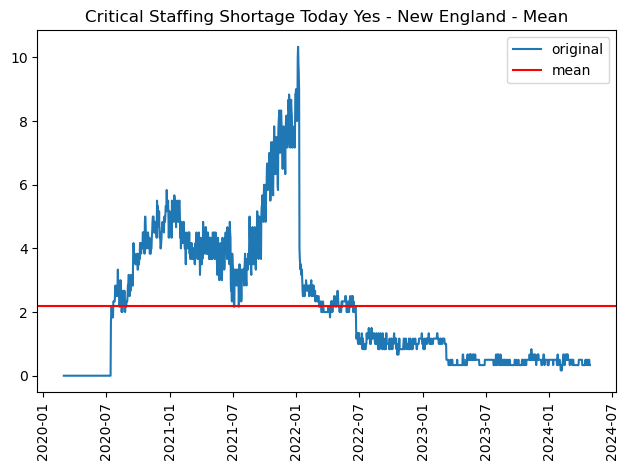

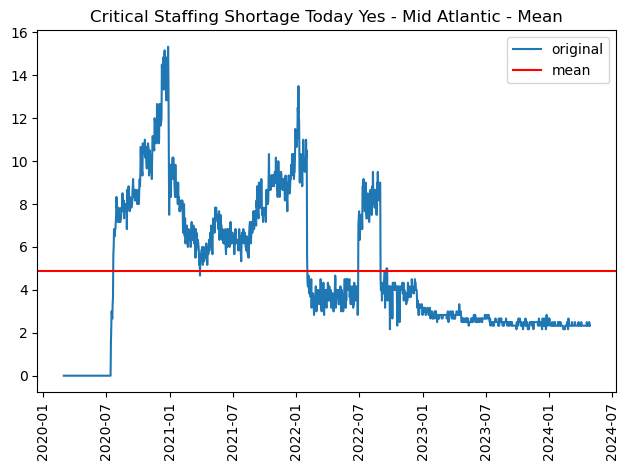

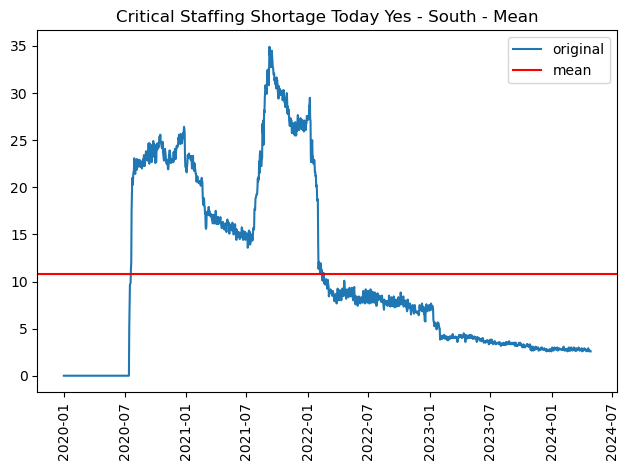

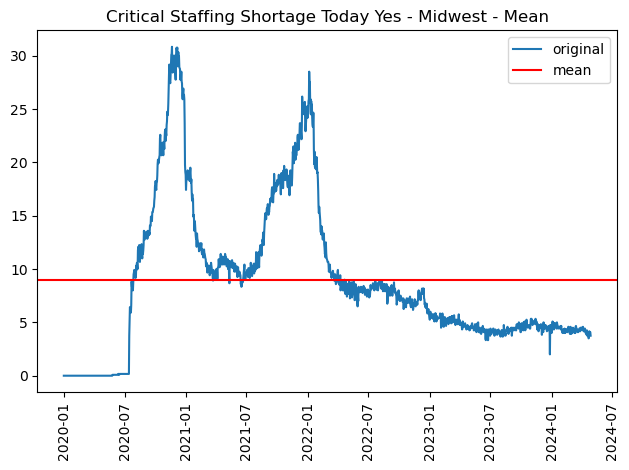

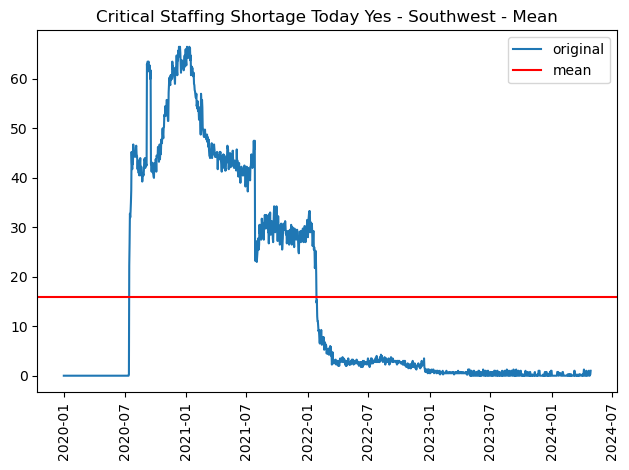

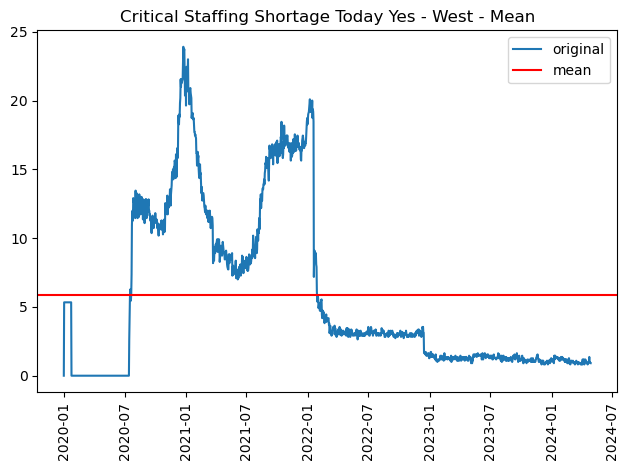

In [16]:
for region, val in dfs_region_map.items():
    means = dfs_region_map[region]["critical_staffing_shortage_today_yes"]
    plt.figure()
    plt.plot(means.index, means, label="original")
    plt.axhline(region_means[region], color="red", label="mean")
    plt.title(f"Critical Staffing Shortage Today Yes - {region} - Mean")
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"../img/mean_model_{region.lower().replace(" ","_")}.png", format="png", dpi=300)
    plt.show()

In [13]:
features_by_region, coefs_by_region = df_processing.get_features_by_region(dfs_region_map, scaled=True)

/opt/anaconda3/envs/capstone/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.948e+00, tolerance: 5.516e-01
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/capstone/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.736e-01, tolerance: 5.516e-01
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/capstone/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing reg

In [15]:
def get_accuracies_model_and_predictions(model, dfs_region_map, coefs):
    best_accs_region = {}
    for region in dfs_region_map.keys():
        df = dfs_region_map[region]
        X = df[coefs[region]]
        y = df["critical_staffing_shortage_today_yes"]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
        my_scaler = StandardScaler()
        X_train_scaled = my_scaler.fit_transform(X_train)
        X_test_scaled = my_scaler.transform(X_test)
        model.fit(X_train_scaled, y_train)
        test_accuracy = model.score(X_test_scaled, y_test)
        predictions = model.predict(X_test_scaled)
        best_accs_region[region] = test_accuracy, X_test, predictions, y_test

    return best_accs_region

In [17]:
accs_region = get_accuracies_model_and_predictions(LinearRegression(), dfs_region_map, features_by_region)

In [19]:
{k:v[0] for k,v in accs_region.items()}

{'New England': 0.9625530812132542,
 'Mid Atlantic': 0.915420193198636,
 'South': 0.9695122436174112,
 'Midwest': 0.985157514440196,
 'Southwest': 0.9931344736885651,
 'West': 0.9728233027232137}

In [21]:
rolling_dfs = {}

for i in range(1, 101):
    rolling_dfs[f"rolling_dfs_region_{i}"] = {}
    for region, df in dfs_region_map.items():
        rolling_dfs[f"rolling_dfs_region_{i}"][region] = df_processing.create_rolling_df(df, i, ignore_columns=["critical_staffing_shortage_today_yes"])

In [23]:
features_by_region_lagged = {}

for i in range(1, 101):
    features_by_region_lagged[f"features_by_region_{i}"] = {}
    for region, features in features_by_region.items():
        features_by_region_lagged[f"features_by_region_{i}"][region] = [f"{col}-{i}" for col in features]

In [25]:
accs = {
    'New England': [],
    'Mid Atlantic': [],
    'South': [],
    'Midwest': [],
    'Southwest': [],
    'West': []
}

preds = {
    'New England': [],
    'Mid Atlantic': [],
    'South': [],
    'Midwest': [],
    'Southwest': [],
    'West': []
}

errors = {
    'New England': [],
    'Mid Atlantic': [],
    'South': [],
    'Midwest': [],
    'Southwest': [],
    'West': []
}

for i in range(1, 101):
    accs_region = get_accuracies_model_and_predictions(LinearRegression(), rolling_dfs[f"rolling_dfs_region_{i}"], features_by_region_lagged[f"features_by_region_{i}"])
    for region, val in accs_region.items():
        accs[region].append(val[0])
        preds[region].append((val[1],val[2]))
        errors[region].append(mean_absolute_error(val[3],val[2]))

In [235]:
sel = mid_atlantic_df["state"] != "NY"
mid_atlantic_no_ny = mid_atlantic_df[sel]

In [33]:
rolling_dfs_mid_atlantic = {}

mid_atlantic_map = {
    "Mid Atlantic": mid_atlantic_no_ny
}

for i in range(1, 101):
    rolling_dfs_mid_atlantic[f"rolling_dfs_region_{i}"] = {}
    for region, df in mid_atlantic_map.items():
        rolling_dfs_mid_atlantic[f"rolling_dfs_region_{i}"][region] = df_processing.create_rolling_df(df, i, ignore_columns=["critical_staffing_shortage_today_yes"])

In [259]:
accs_no_ny = {
    'Mid Atlantic': []
}

preds_no_ny = {
    'Mid Atlantic': []
}

for i in range(1, 101):
    accs_region = get_accuracies_model_and_predictions(LinearRegression(), rolling_dfs_mid_atlantic[f"rolling_dfs_region_{i}"], features_by_region_lagged[f"features_by_region_{i}"])
    for region, val in accs_region.items():
        accs_no_ny[region].append(val[0])
        preds_no_ny[region].append((val[1],val[2]))

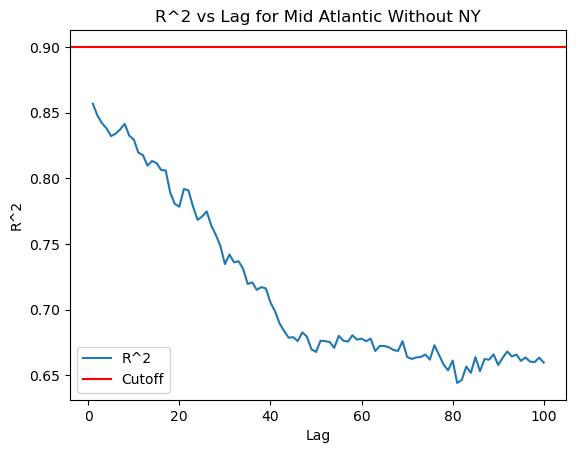

In [261]:
for region, acc in accs_no_ny.items():
    plt.figure()
    plt.plot(range(1,101), acc, label="R^2")
    plt.title(f"R^2 vs Lag for {region} Without NY - Linear Regression")
    plt.axhline(.90, color="red", label="Cutoff")
    plt.xlabel("Lag")
    plt.ylabel("R^2")
    plt.legend()
    plt.show()

In [27]:
def get_best_worst_r2(r2s):
    accs_best_worst = {}
    for region, accs in r2s.items():
        best = np.argmax(accs)
        worst = np.argmin(accs)
        accs_best_worst[region] = (best, worst)
    return accs_best_worst

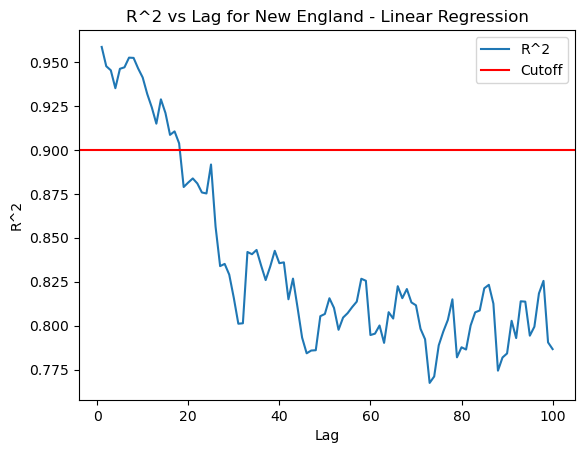

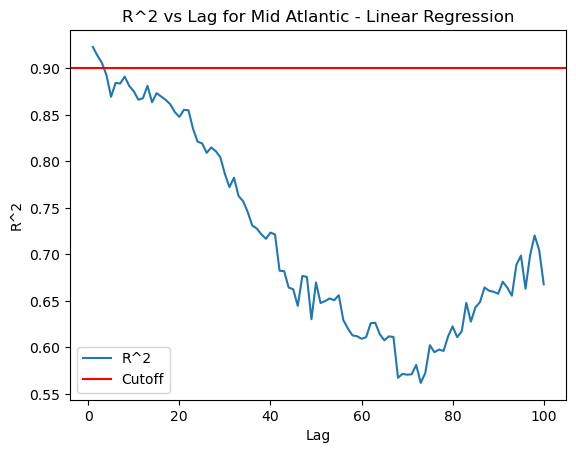

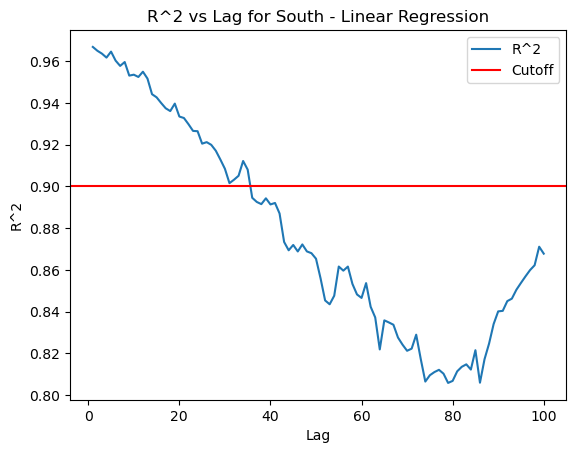

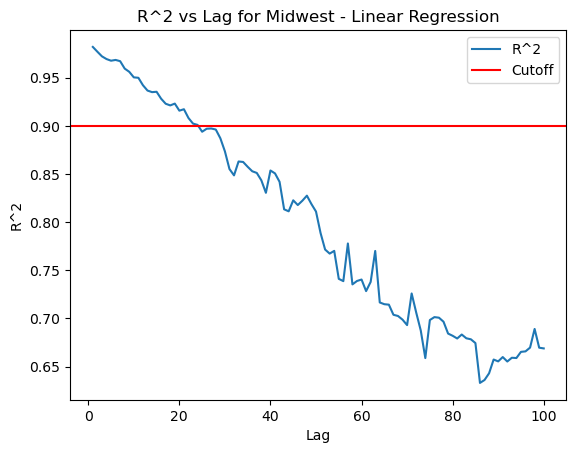

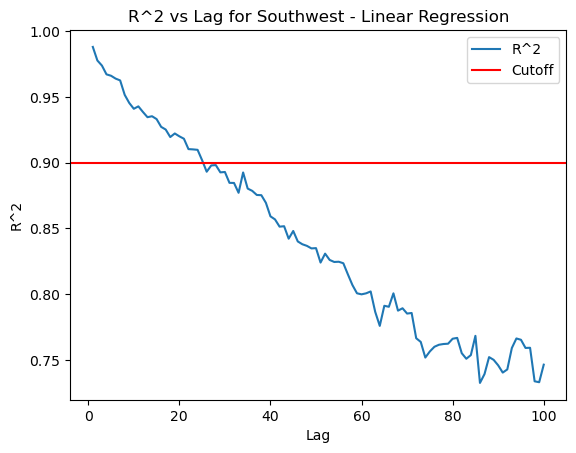

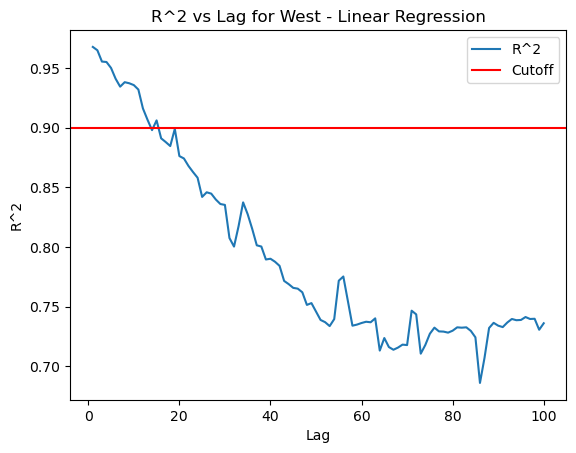

In [34]:
for region, acc in accs.items():
    plt.figure()
    plt.plot(range(1,101), acc, label="R^2")
    plt.title(f"R^2 vs Lag for {region} - Linear Regression")
    plt.axhline(.90, color="red", label="Cutoff")
    plt.xlabel("Lag")
    plt.ylabel("R^2")
    plt.legend()
    plt.savefig(f"../img/r2_{region.lower().replace(" ","_")}_lr.png", format="png", dpi=300)
    plt.show()

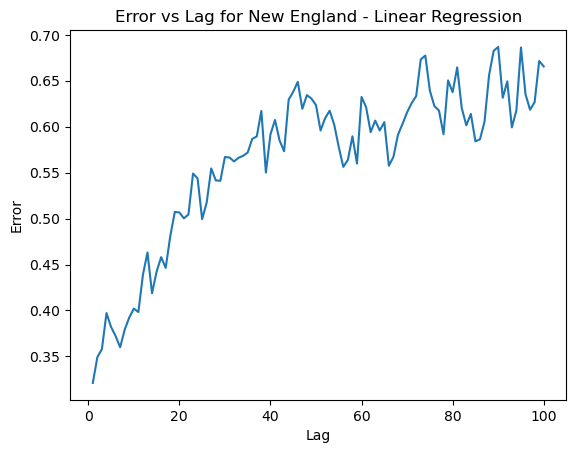

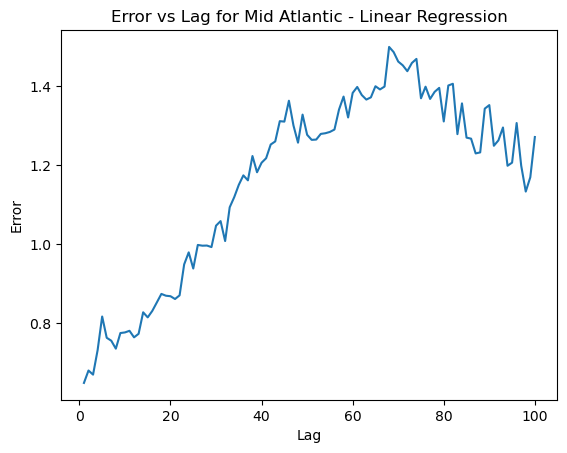

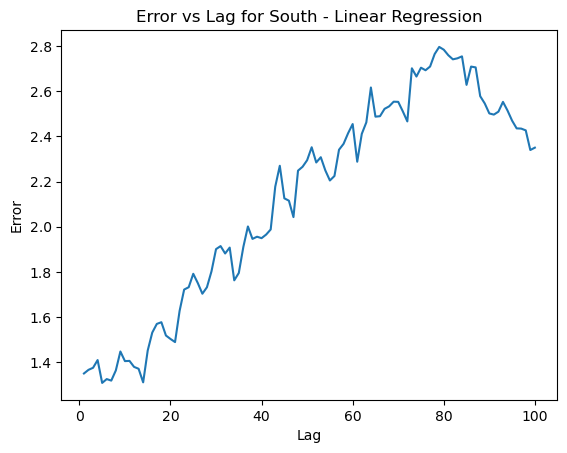

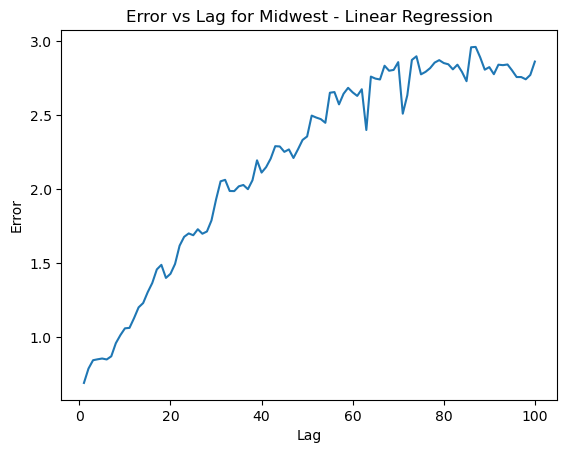

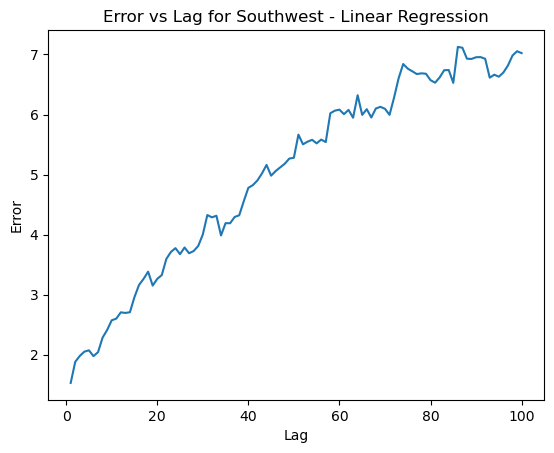

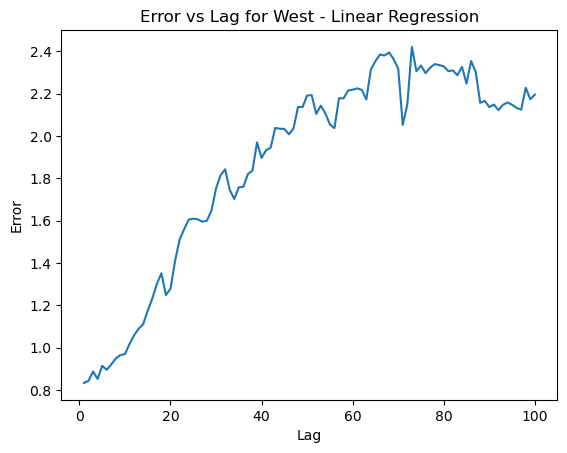

In [36]:
for region, error in errors.items():
    plt.figure()
    plt.plot(range(1,101), error)
    plt.title(f"Error vs Lag for {region} - Linear Regression")
    plt.xlabel("Lag")
    plt.ylabel("Error")
    plt.savefig(f"../img/error_model_{region.lower().replace(" ","_")}_lr.png", format="png", dpi=300)
    plt.show()

In [29]:
best_worst_r2s_linear = get_best_worst_r2(accs)
best_worst_r2s_linear

{'New England': (0, 72),
 'Mid Atlantic': (0, 72),
 'South': (0, 78),
 'Midwest': (0, 85),
 'Southwest': (0, 85),
 'West': (0, 85)}

In [774]:
print(accs["Mid Atlantic"][best_worst_r2s_linear["Mid Atlantic"][0]], accs["Mid Atlantic"][best_worst_r2s_linear["Mid Atlantic"][1]])

0.9231267365772338 0.5617676092913606


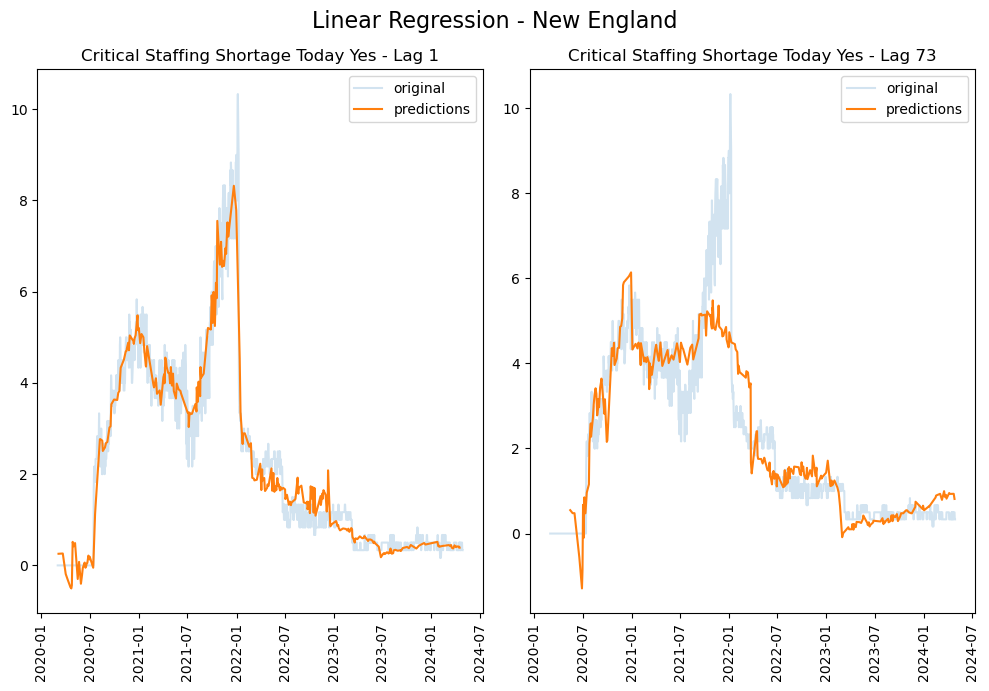

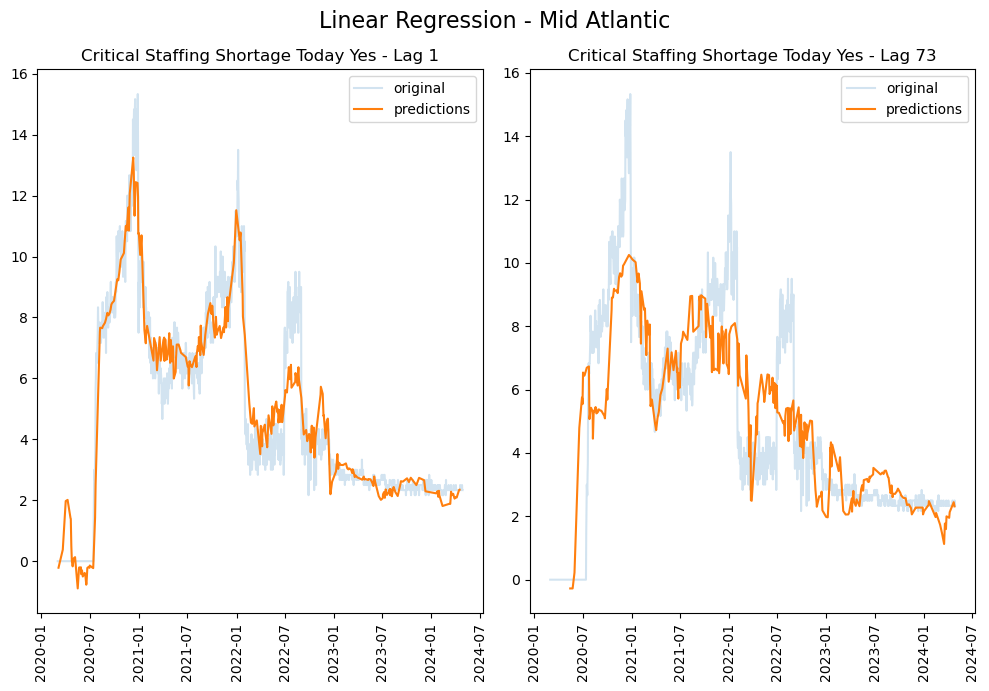

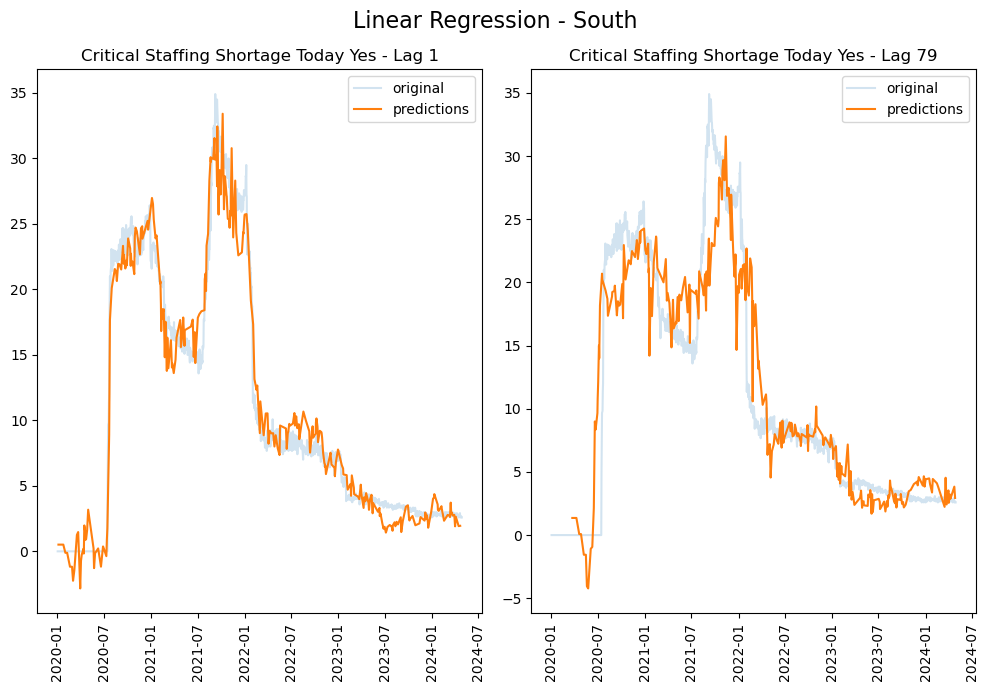

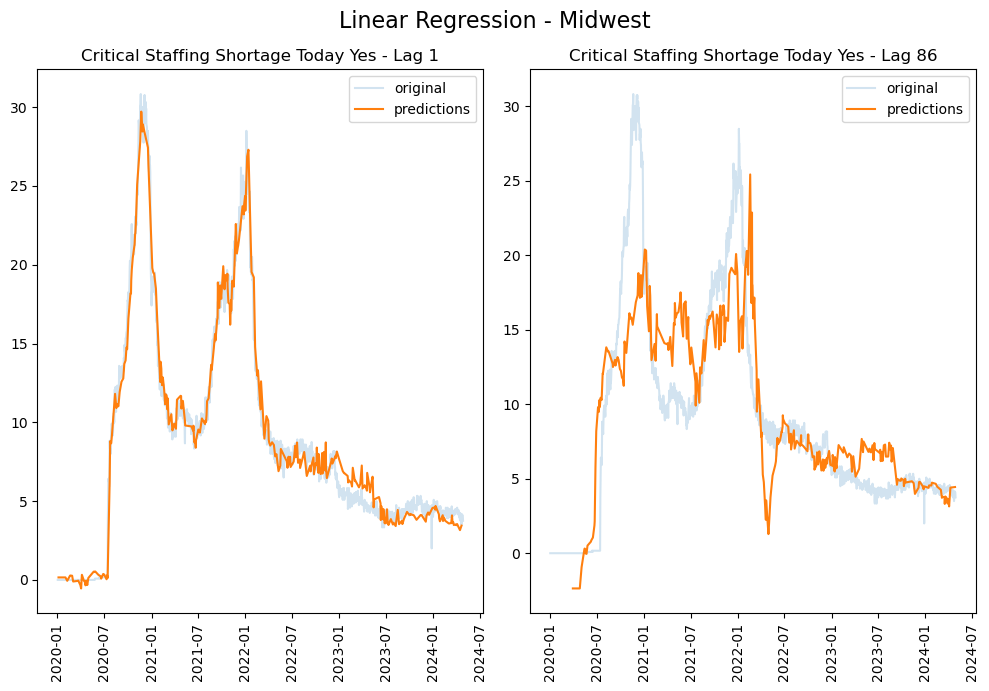

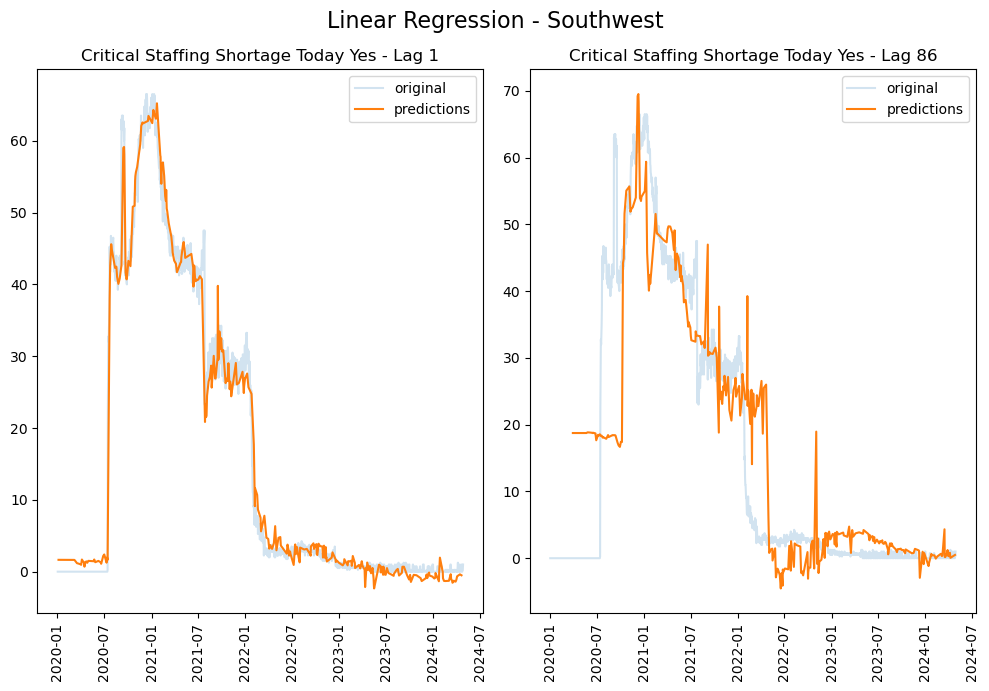

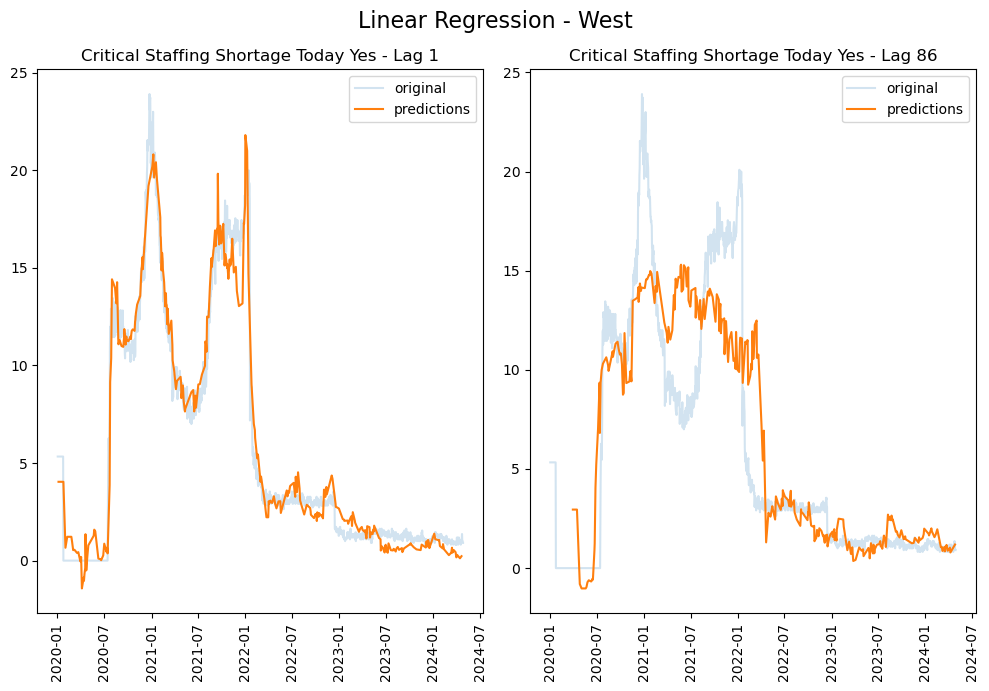

In [760]:
for region, val in preds.items():
    best, worst = best_worst_r2s_linear[region]
    means = rolling_dfs["rolling_dfs_region_1"][region]["critical_staffing_shortage_today_yes"]
    test, pred = preds[region][best]
    p = pd.DataFrame(data=pred, index=test.index).sort_values(by="date")
    plt.subplots(1,2, figsize=(10,7), tight_layout=True)
    plt.suptitle(f'Linear Regression - {region}', fontsize=16)
    
    plt.subplot(1,2,1)
    plt.plot(means.index, means, label="original", alpha=0.2)
    plt.plot(p.index, p, label="predictions")
    plt.title(f"Critical Staffing Shortage Today Yes - Lag {best + 1}")
    plt.xticks(rotation=90)
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(means.index, means, label="original", alpha=0.2)
    test, pred = preds[region][worst]
    p = pd.DataFrame(data=pred, index=test.index).sort_values(by="date")
    plt.plot(p.index, p, label="predictions")
    plt.title(f"Critical Staffing Shortage Today Yes - Lag {worst + 1}")
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"../img/lr_model_{region.lower().replace(" ","_")}.png", format="png", dpi=300)
    plt.show()

In [87]:
accs_xgb = {
    'New England': [],
    'Mid Atlantic': [],
    'South': [],
    'Midwest': [],
    'Southwest': [],
    'West': []
}

preds_xgb = {
    'New England': [],
    'Mid Atlantic': [],
    'South': [],
    'Midwest': [],
    'Southwest': [],
    'West': []
}

errors_xgb = {
    'New England': [],
    'Mid Atlantic': [],
    'South': [],
    'Midwest': [],
    'Southwest': [],
    'West': []
}

for i in range(1, 101):
    accs_region = get_accuracies_model_and_predictions(XGBRegressor(), rolling_dfs[f"rolling_dfs_region_{i}"], features_by_region_lagged[f"features_by_region_{i}"])
    for region, val in accs_region.items():
        accs_xgb[region].append(val[0])
        preds_xgb[region].append((val[1],val[2]))
        errors_xgb[region].append(mean_absolute_error(val[3],val[2]))

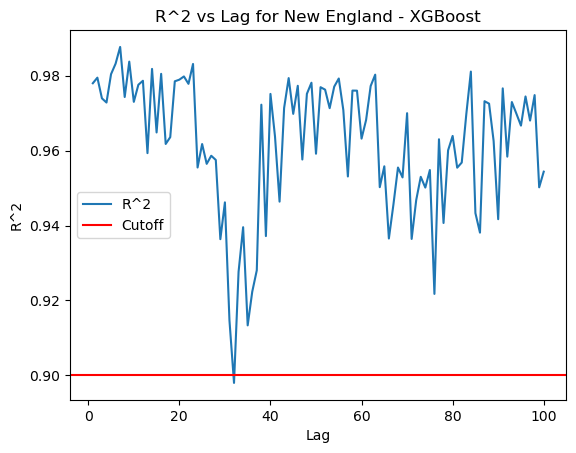

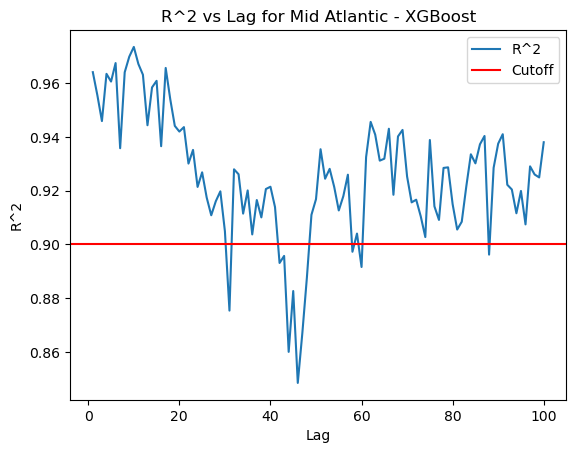

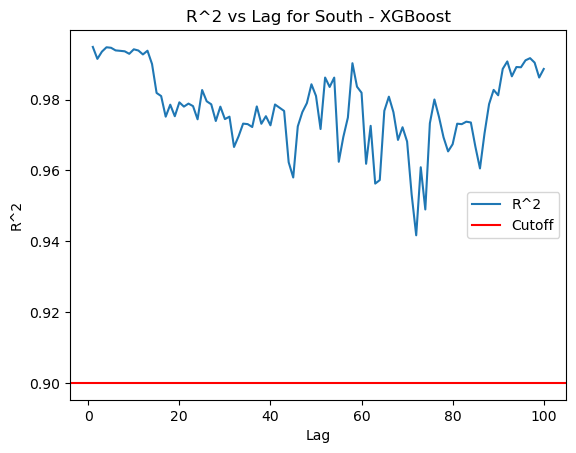

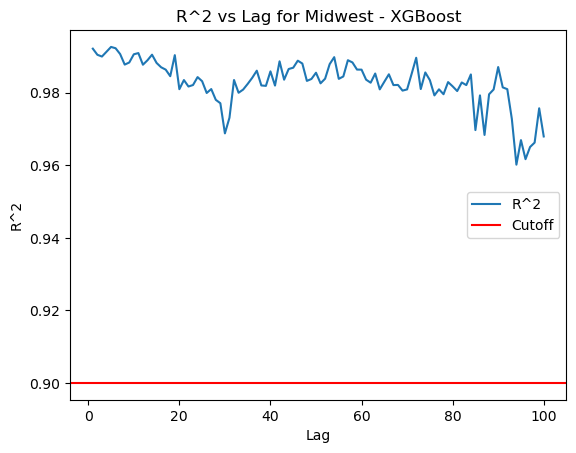

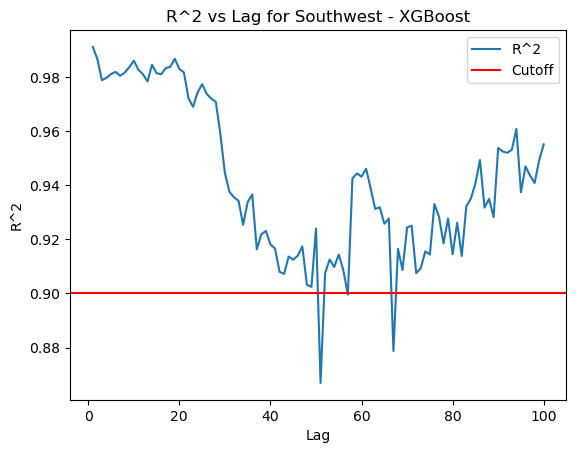

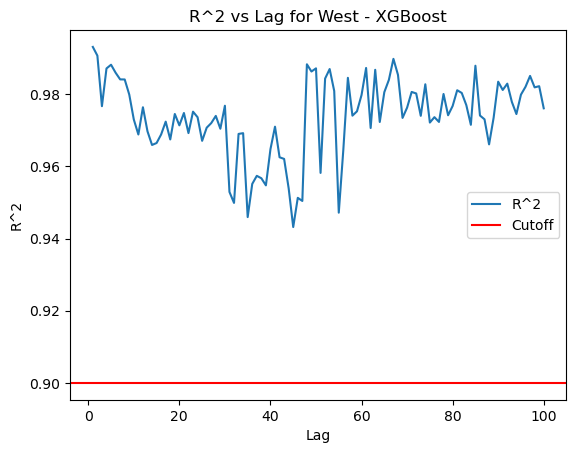

In [734]:
for region, acc in accs_xgb.items():
    plt.figure()
    plt.plot(range(1,101), acc, label="R^2")
    plt.title(f"R^2 vs Lag for {region} - XGBoost")
    plt.axhline(.90, color="red", label="Cutoff")
    plt.xlabel("Lag")
    plt.ylabel("R^2")
    plt.legend()
    plt.savefig(f"../img/r2_{region.lower().replace(" ","_")}_xgb.png", format="png", dpi=300)
    plt.show()

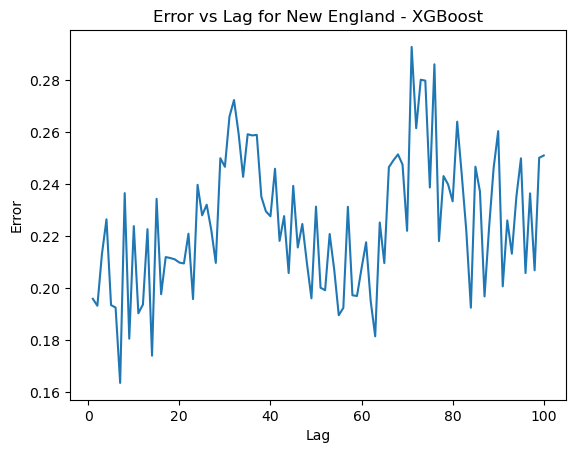

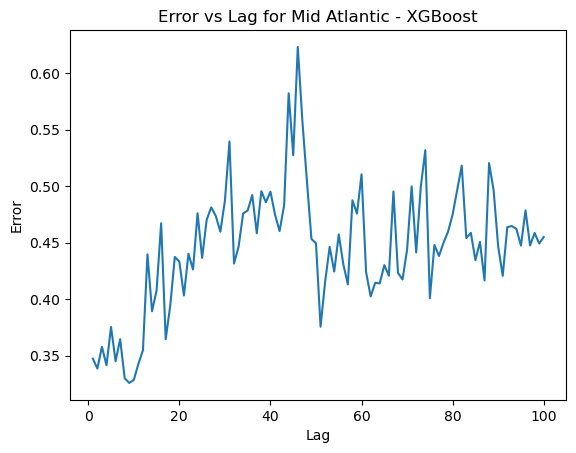

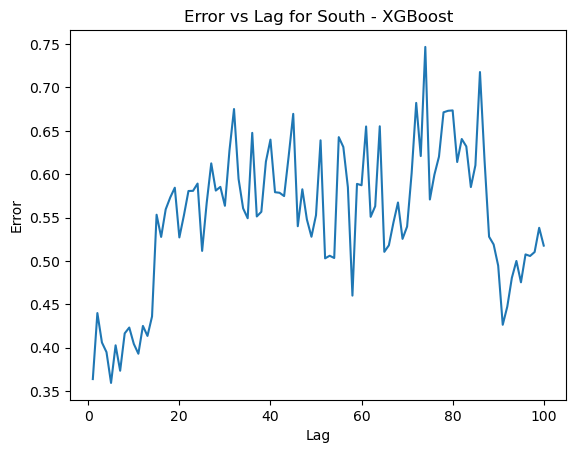

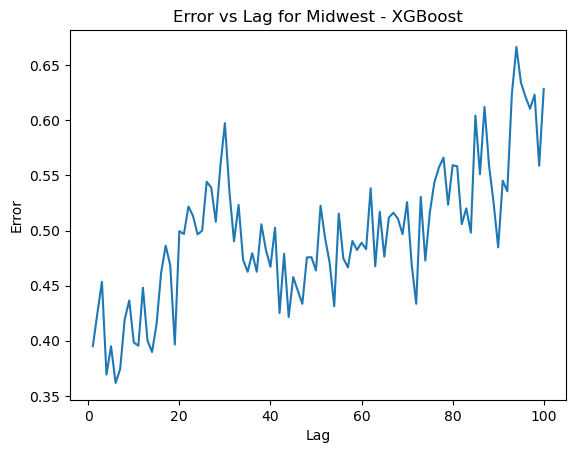

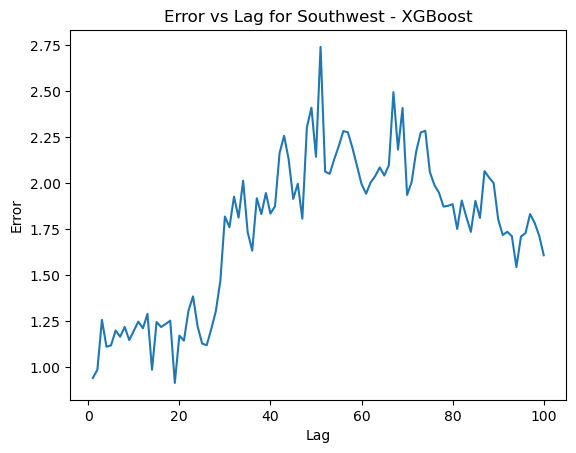

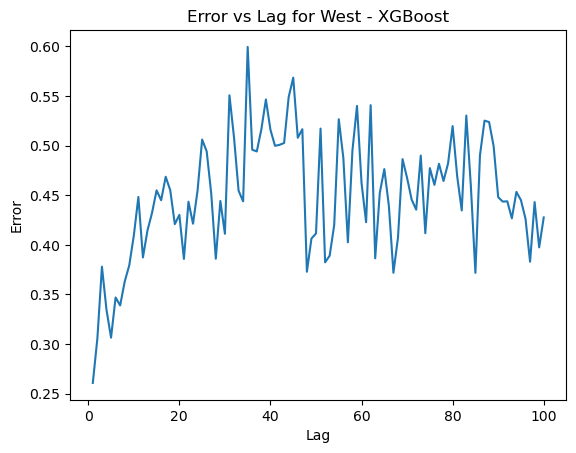

In [736]:
for region, error in errors_xgb.items():
    plt.figure()
    plt.plot(range(1,101), error)
    plt.title(f"Error vs Lag for {region} - XGBoost")
    plt.xlabel("Lag")
    plt.ylabel("Error")
    plt.savefig(f"../img/error_model_{region.lower().replace(" ","_")}_xgb.png", format="png", dpi=300)
    plt.show()

In [89]:
best_worst_r2s_xgb = get_best_worst_r2(accs_xgb)
best_worst_r2s_xgb

{'New England': (6, 31),
 'Mid Atlantic': (9, 45),
 'South': (0, 71),
 'Midwest': (4, 93),
 'Southwest': (0, 50),
 'West': (0, 44)}

In [776]:
print(accs_xgb["Mid Atlantic"][best_worst_r2s_xgb["Mid Atlantic"][0]], accs_xgb["Mid Atlantic"][best_worst_r2s_xgb["Mid Atlantic"][1]])

0.9734728163920758 0.84849362651707


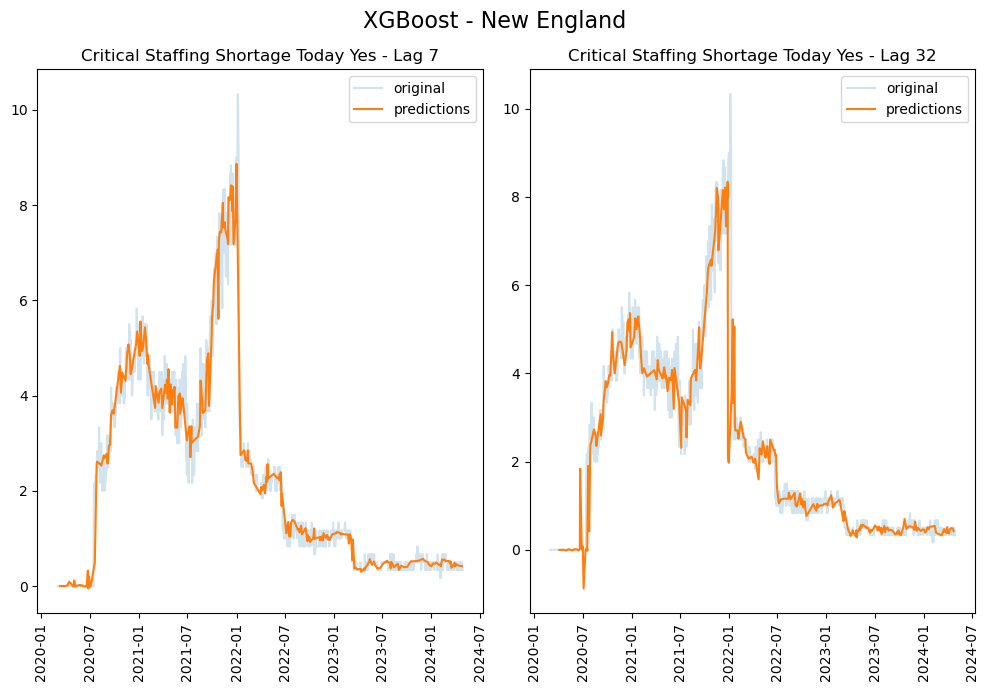

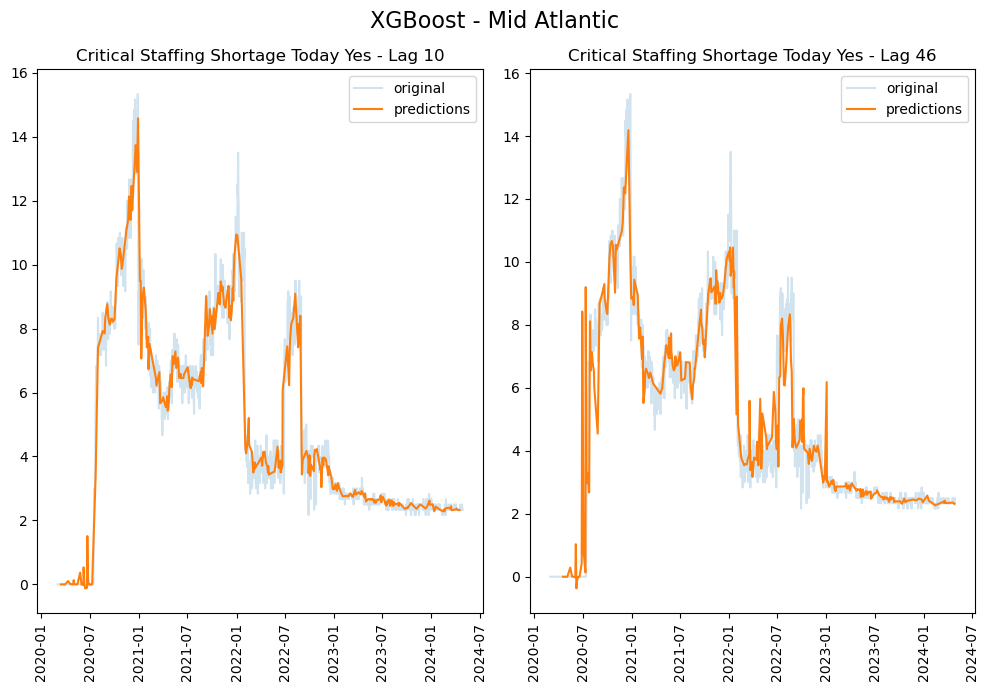

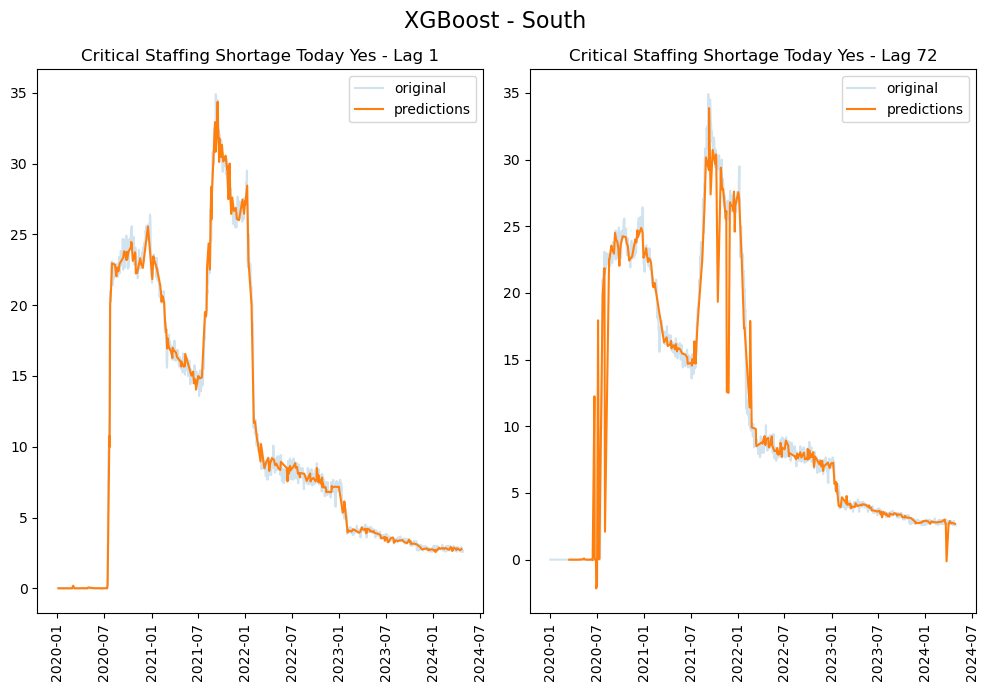

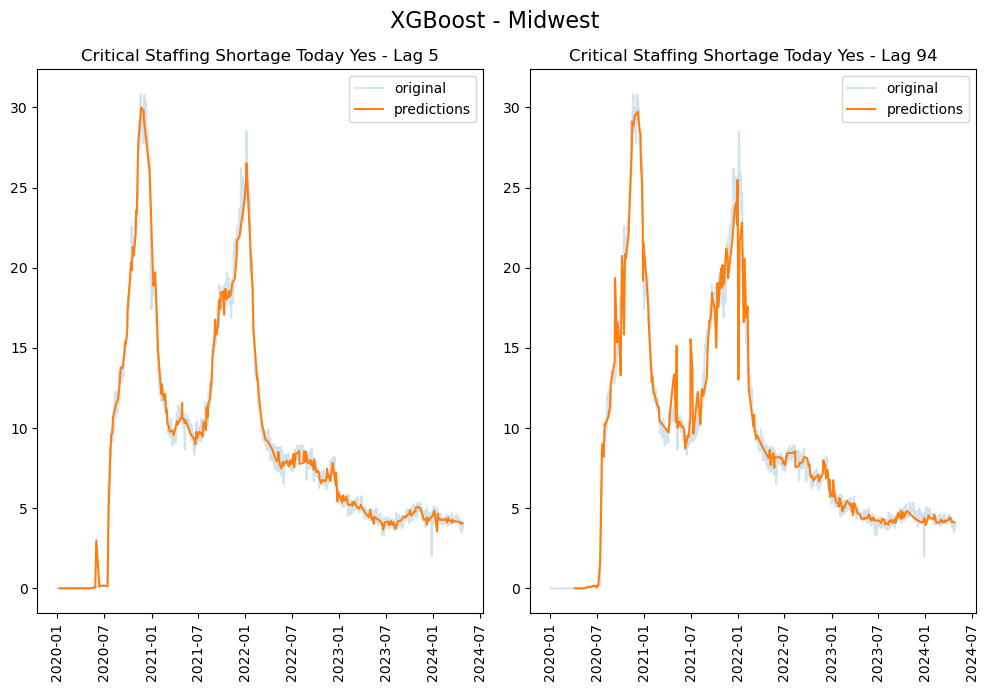

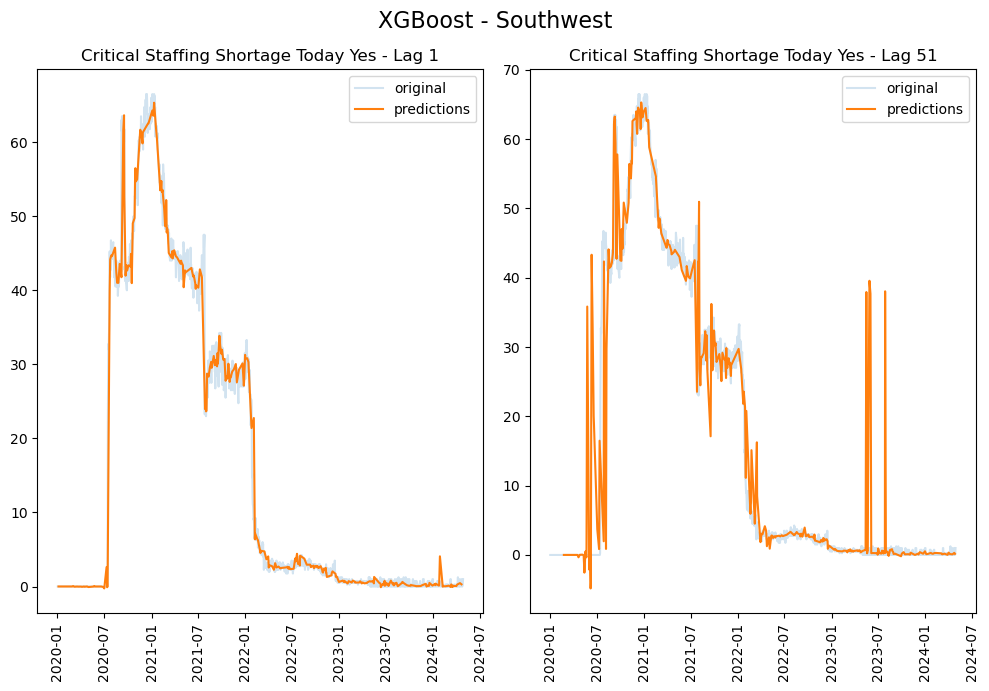

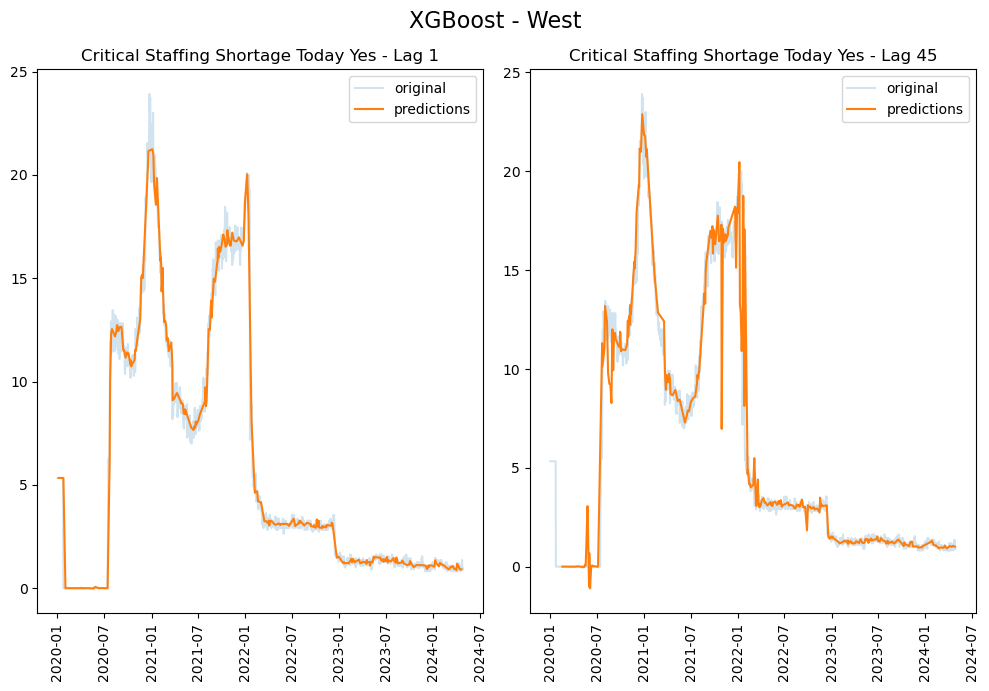

In [766]:
# get best model index
for region, val in preds_xgb.items():
    best, worst = best_worst_r2s_xgb[region]
    means = rolling_dfs["rolling_dfs_region_1"][region]["critical_staffing_shortage_today_yes"]
    test, pred = preds_xgb[region][best]
    p = pd.DataFrame(data=pred, index=test.index).sort_values(by="date")
    plt.subplots(1,2, figsize=(10,7), tight_layout=True)
    plt.suptitle(f'XGBoost - {region}', fontsize=16)
    
    plt.subplot(1,2,1)
    plt.plot(means.index, means, label="original", alpha=0.2)
    plt.plot(p.index, p, label="predictions")
    plt.title(f"Critical Staffing Shortage Today Yes - Lag {best + 1}")
    plt.xticks(rotation=90)
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(means.index, means, label="original", alpha=0.2)
    test, pred = preds_xgb[region][worst]
    p = pd.DataFrame(data=pred, index=test.index).sort_values(by="date")
    plt.plot(p.index, p, label="predictions")
    plt.title(f"Critical Staffing Shortage Today Yes - Lag {worst + 1}")
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"../img/xgb_model_{region.lower().replace(" ","_")}.png", format="png", dpi=300)
    plt.show()

In [103]:
class SimpleNN(nn.Module):
    """Basic multi-layer architecture."""

    def __init__(self, columns):
        """Define the main components of the network"""
        super(SimpleNN, self).__init__()

        self.layer_1 = nn.Linear(columns, 32) # transition from input into hidden layer
        self.activation_1 = nn.ReLU()   # Activation function
        self.layer_2 = nn.Linear(32, 16)  # transition from hidden layer into output
        self.activation_2 = nn.ReLU()
        self.layer_3 = nn.Linear(16, 8)
        self.activation_3 = nn.ReLU()
        self.layer_4 = nn.Linear(8, 2)

        # Declare a regression layer
        self.regression_layer = nn.Linear(2,1)

    def forward(self, x):
        """Perform forward pass."""

        # pass through the layers
        hidden_1 = self.activation_1(self.layer_1(x))
        hidden_2 = self.layer_2(hidden_1)
        hidden_3 = self.layer_3(self.activation_2(hidden_2))
        hidden_4 = self.layer_4(self.activation_3(hidden_3))

        # Notice the network will behave differently based on
        # whether it is training or not
        output = self.regression_layer(hidden_4)

        # return output
        return output

In [630]:
X = rolling_dfs["rolling_dfs_region_1"]["Mid Atlantic"].drop(columns=["critical_staffing_shortage_today_yes"])
y = rolling_dfs["rolling_dfs_region_1"]["Mid Atlantic"][["critical_staffing_shortage_today_yes"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
my_scaler = StandardScaler()
X_train_scaled = my_scaler.fit_transform(X_train)
X_test_scaled = my_scaler.transform(X_test)

# We have to turn the data into tensors, and in this case,
# convert the type from np.float64 to torch.float32
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

In [632]:
# Instantiate the model, the loss criterion, and the optimizer
NN_model = SimpleNN(X_train_tensor.shape[1])

l1_loss = nn.L1Loss() # this includes the softmax
optimizer = torch.optim.SGD(NN_model.parameters(), lr=.01, momentum=0.9)

In [634]:
for epoch in tnrange(500, desc="Total epochs: "):

    # Clear gradients (pytorch accumulates gradients by default)
    optimizer.zero_grad()

    # Calculate outputs
    output_values = NN_model(X_train_tensor)

    # Calculate loss
    loss = l1_loss(output_values, y_train_tensor)

    # Backpropagation & weight adjustment
    loss.backward()
    optimizer.step()

Total epochs:   0%|          | 0/500 [00:00<?, ?it/s]

In [636]:
from sklearn.metrics import mean_squared_error
test_pred = NN_model(X_test_tensor)

error = mean_squared_error(y_test_tensor.numpy(), test_pred.detach().numpy())
error = round(error, 2)
error

0.28

In [339]:
rolling_dfs["rolling_dfs_region_1"]["New England"].shape

(1518, 107)

In [608]:
test_pred.detach().numpy().size

304

In [678]:
accs_nn_1 = {
    'New England': [],
    'Mid Atlantic': [],
    'South': [],
    'Midwest': [],
    'Southwest': [],
    'West': []
}

preds_nn_1 = {
    'New England': [],
    'Mid Atlantic': [],
    'South': [],
    'Midwest': [],
    'Southwest': [],
    'West': []
}

errors_nn_1 = {
    'New England': [],
    'Mid Atlantic': [],
    'South': [],
    'Midwest': [],
    'Southwest': [],
    'West': []
}

accs_region = run_neural_net(rolling_dfs["rolling_dfs_region_1"], features_by_region_lagged["features_by_region_1"])
for region, val in accs_region.items():
    accs_nn_1[region].append(val[0])
    preds_nn_1[region].append((val[1],val[2]))
    errors_nn_1[region].append(val[3])

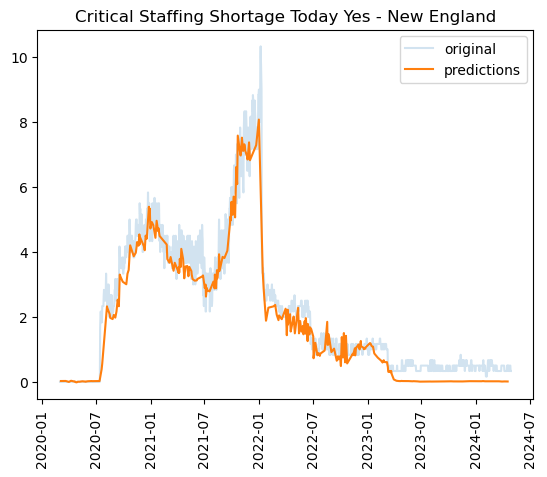

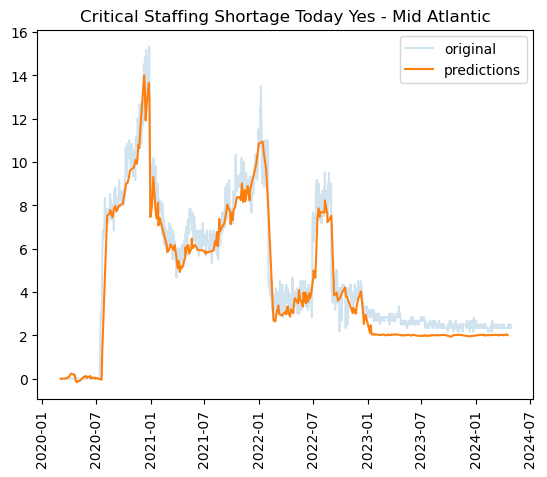

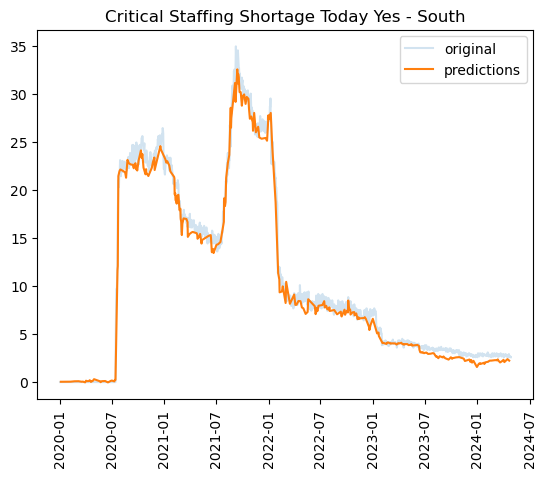

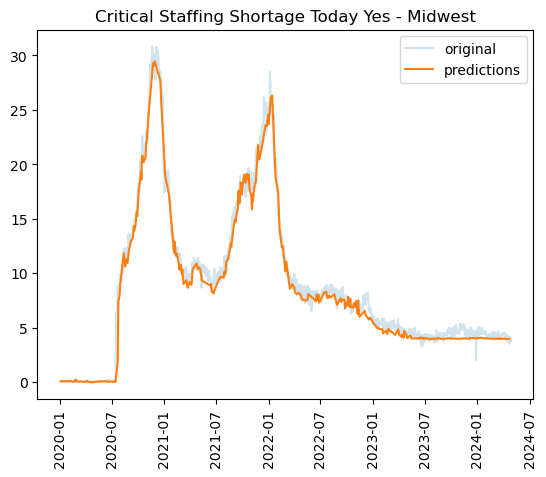

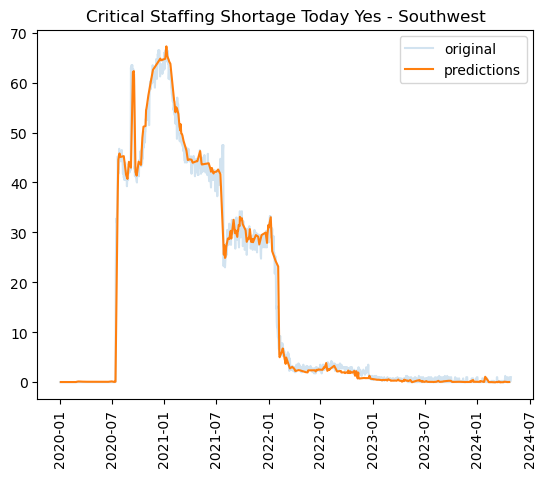

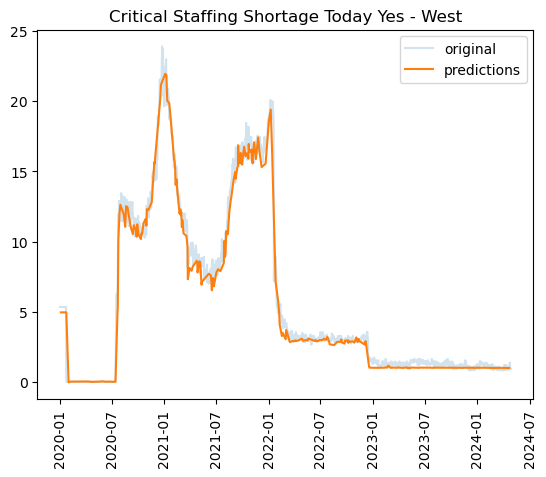

In [680]:
for region, val in preds_nn.items():
    means = rolling_dfs["rolling_dfs_region_1"][region]["critical_staffing_shortage_today_yes"]
    test, pred = preds_nn_1[region][0]
    p = pd.DataFrame(data=pred.detach().numpy().reshape(pred.detach().numpy().size, -1), index=test.index).sort_values(by="date")
    
    plt.plot(means.index, means, label="original", alpha=0.2)
    plt.plot(p.index, p, label="predictions")
    plt.title(f"Critical Staffing Shortage Today Yes - {region}")
    plt.xticks(rotation=90)
    plt.legend()

    plt.show()

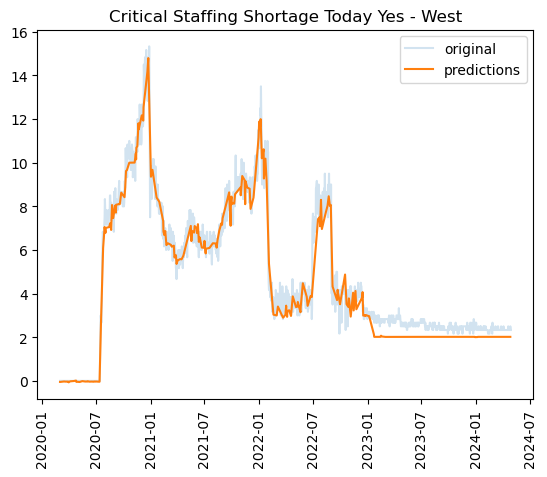

In [638]:
means = rolling_dfs["rolling_dfs_region_1"]["Mid Atlantic"]["critical_staffing_shortage_today_yes"]
p = pd.DataFrame(test_pred.detach().numpy().reshape(test_pred.detach().numpy().size, -1), index=X_test.index).sort_values(by="date")
plt.plot(means.index, means, label="original", alpha=0.2)
plt.plot(p.index, p, label="predictions")
plt.title(f"Critical Staffing Shortage Today Yes - {region}")
plt.xticks(rotation=90)
plt.legend()

plt.show()

In [199]:
train_acc = torch.sum(y_test_tensor == test_pred.round())/len(y_test_tensor)
train_acc

tensor(0.8158)

In [116]:
model = LinearRegression().fit(X_train, y_train)
model.predict(pd.DataFrame(X_test.iloc[15]).T)[0][0]

2.3702349282861874

In [520]:
# adapted from https://visualstudiomagazine.com/Articles/2022/11/14/pytorch-regression-2.aspx#:~:text=For%20regression%20problem%20accuracy%2C%20you,counted%20as%20a%20correct%20prediction.

def accuracy(model, X, Y, pct_close):
  n_correct = 0; n_wrong = 0
  for i in range(X.size(0)):
    x = X[i]   # 2-d inputs
    y = Y[i]   # 2-d target
    with torch.no_grad():
      oupt = model(x)  # computed income

    if torch.abs(oupt - y) < torch.abs(pct_close * y):
      n_correct += 1
    else:
      n_wrong += 1
  acc = (n_correct * 1.0) / (n_correct + n_wrong)
  return acc

In [105]:
def run_neural_net(dfs_region_map, coefs):
    best_accs_region = {}
    for region, df in dfs_region_map.items():
#        df = dfs_region_map[region]
        X = df[coefs[region]]
        y = df[["critical_staffing_shortage_today_yes"]]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
        my_scaler = StandardScaler()
        X_train_scaled = my_scaler.fit_transform(X_train)
        X_test_scaled = my_scaler.transform(X_test)
        
        X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
        
        y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
        y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

        NN_model = SimpleNN(X_train_tensor.shape[1])

        l1_loss = nn.L1Loss() # this includes the softmax
        # Weight decay .01
        optimizer = torch.optim.SGD(NN_model.parameters(), lr=.01, momentum=0.9, weight_decay=0.01)
        
        for epoch in range(500):
            # Clear gradients (pytorch accumulates gradients by default)
            optimizer.zero_grad()
        
            # Calculate outputs
            output_values = NN_model(X_train_tensor)
        
            # Calculate loss
            loss = l1_loss(output_values, y_train_tensor)
        
            # Backpropagation & weight adjustment
            loss.backward()
            optimizer.step()

        test_pred = NN_model(X_test_tensor)
        #acc = accuracy(NN_model, X_test_tensor, y_test_tensor, .10)
        acc = r2_score(y_test_tensor.numpy(), test_pred.detach().numpy())
        error = mean_absolute_error(y_test_tensor.numpy(), test_pred.detach().numpy())
        best_accs_region[region] = acc, X_test, test_pred, error
    return best_accs_region

In [107]:
import warnings
warnings.filterwarnings('ignore')

In [113]:
accs_nn = {
    'New England': [],
    'Mid Atlantic': [],
    'South': [],
    'Midwest': [],
    'Southwest': [],
    'West': []
}

preds_nn = {
    'New England': [],
    'Mid Atlantic': [],
    'South': [],
    'Midwest': [],
    'Southwest': [],
    'West': []
}

errors_nn = {
    'New England': [],
    'Mid Atlantic': [],
    'South': [],
    'Midwest': [],
    'Southwest': [],
    'West': []
}


for i in range(1, 101):
    accs_region = run_neural_net(rolling_dfs[f"rolling_dfs_region_{i}"], features_by_region_lagged[f"features_by_region_{i}"])
    for region, val in accs_region.items():
        accs_nn[region].append(val[0])
        preds_nn[region].append((val[1],val[2]))
        errors_nn[region].append(val[3])

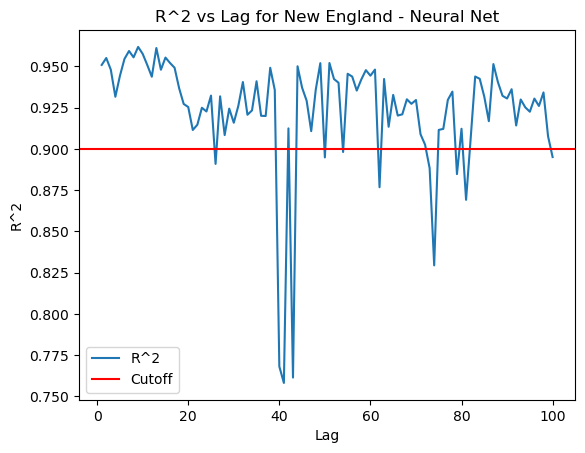

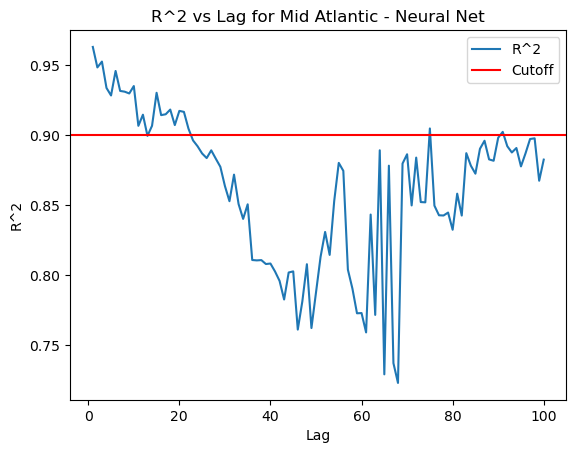

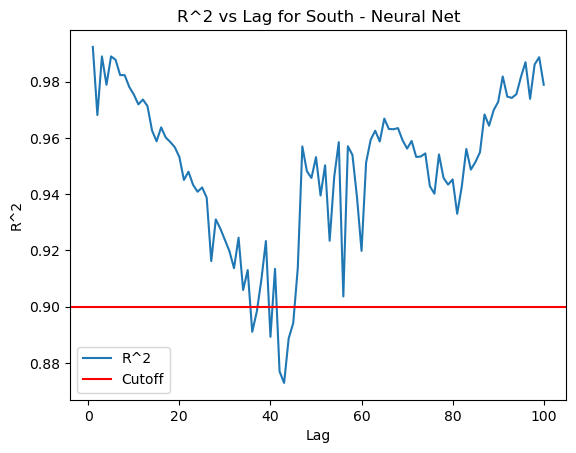

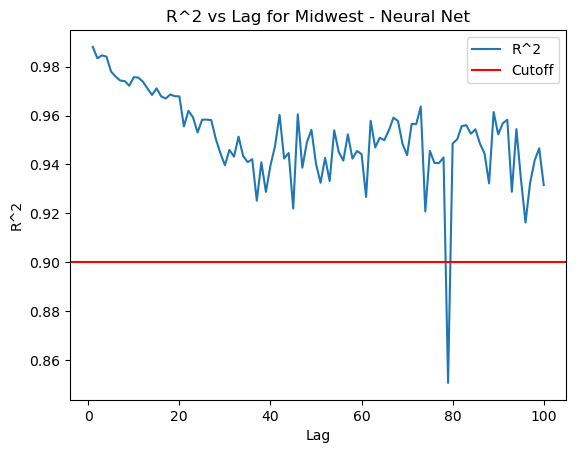

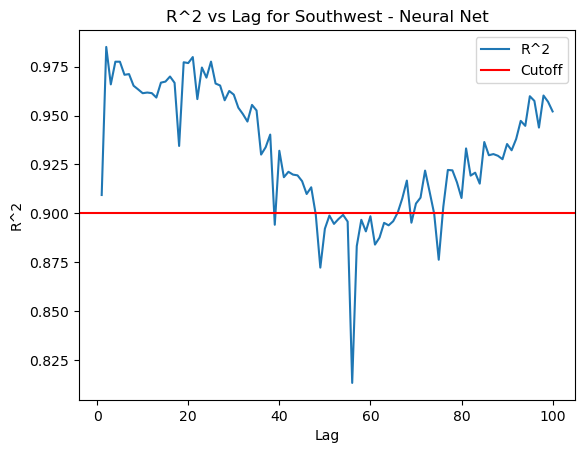

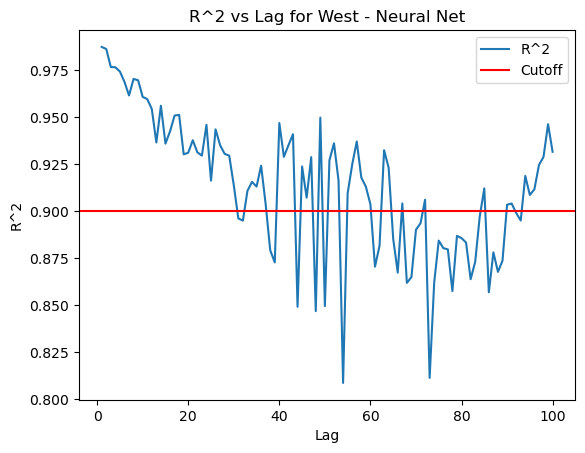

In [750]:
for region, acc in accs_nn.items():
    plt.figure()
    plt.plot(range(1,101), acc, label="R^2")
    plt.title(f"R^2 vs Lag for {region} - Neural Net")
    plt.axhline(.90, color="red", label="Cutoff")
    plt.xlabel("Lag")
    plt.ylabel("R^2")
    plt.legend()
    plt.savefig(f"../img/r2_{region.lower().replace(" ","_")}_nn.png", format="png", dpi=300)
    plt.show()

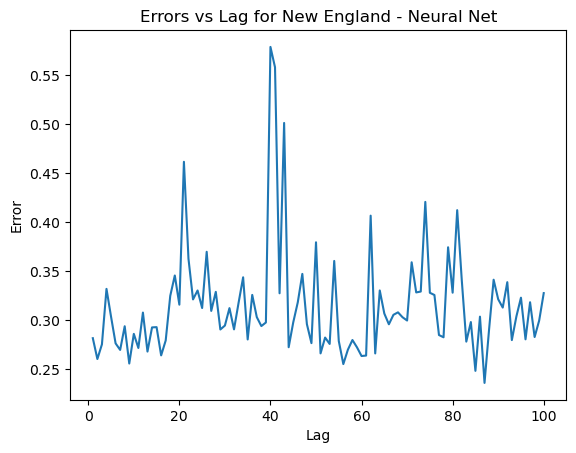

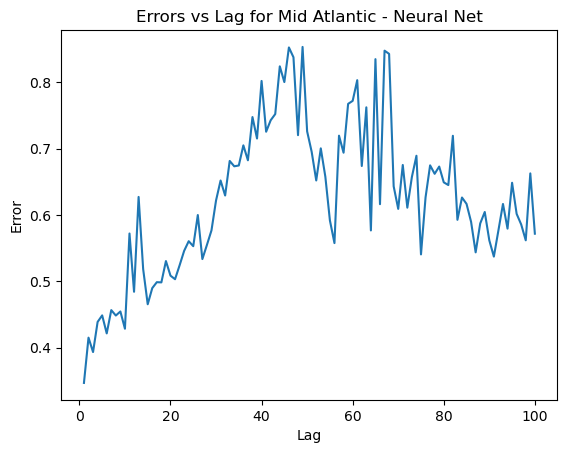

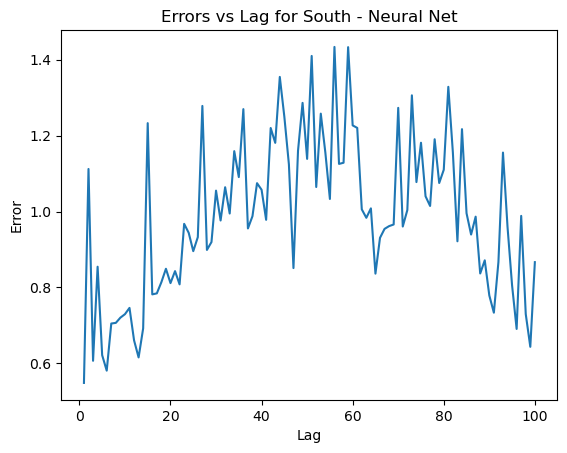

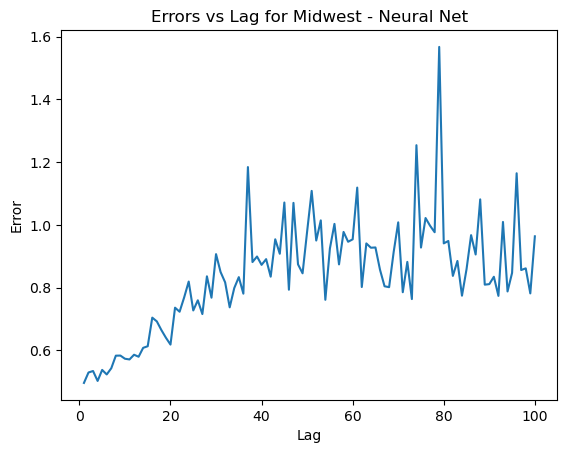

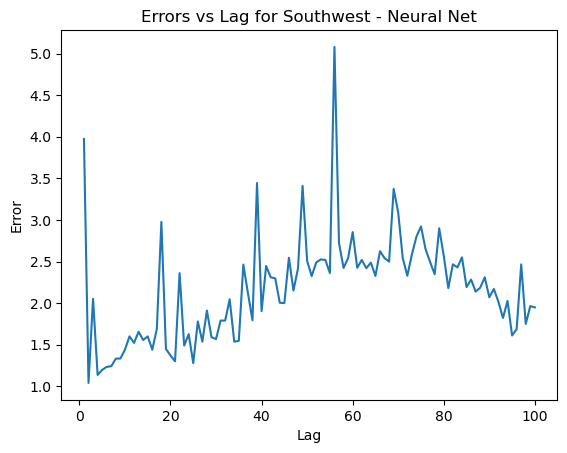

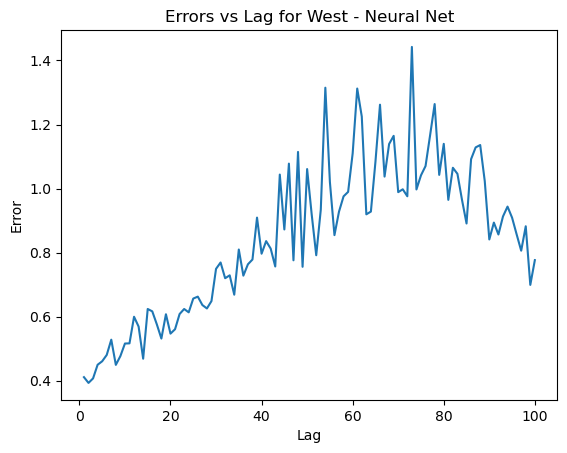

In [754]:
for region, error in errors_nn.items():
    plt.figure()
    plt.plot(range(1,101), error)
    plt.title(f"Errors vs Lag for {region} - Neural Net")
    plt.xlabel("Lag")
    plt.ylabel("Error")
    plt.savefig(f"../img/error_model_{region.lower().replace(" ","_")}_nn.png", format="png", dpi=300)
    plt.show()

In [117]:
best_worst_r2s_nn = get_best_worst_r2(accs_nn)
best_worst_r2s_nn

{'New England': (8, 47),
 'Mid Atlantic': (0, 69),
 'South': (0, 52),
 'Midwest': (0, 85),
 'Southwest': (0, 61),
 'West': (1, 44)}

In [778]:
print(accs_nn["Mid Atlantic"][best_worst_r2s_nn["Mid Atlantic"][0]], accs_nn["Mid Atlantic"][best_worst_r2s_nn["Mid Atlantic"][1]])

0.9631924629211426 0.8521955609321594


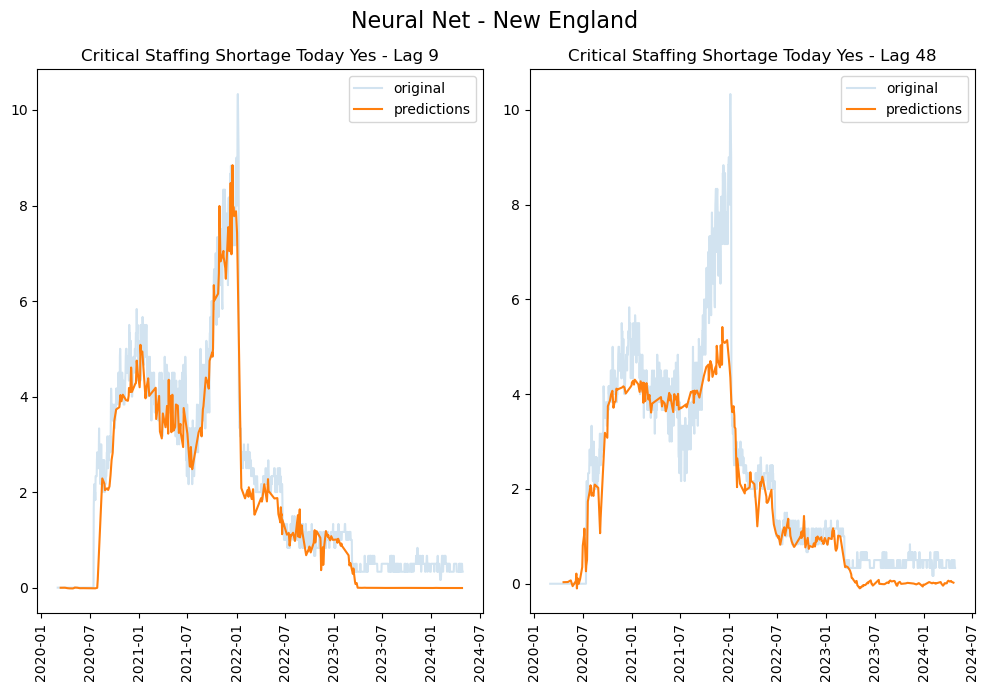

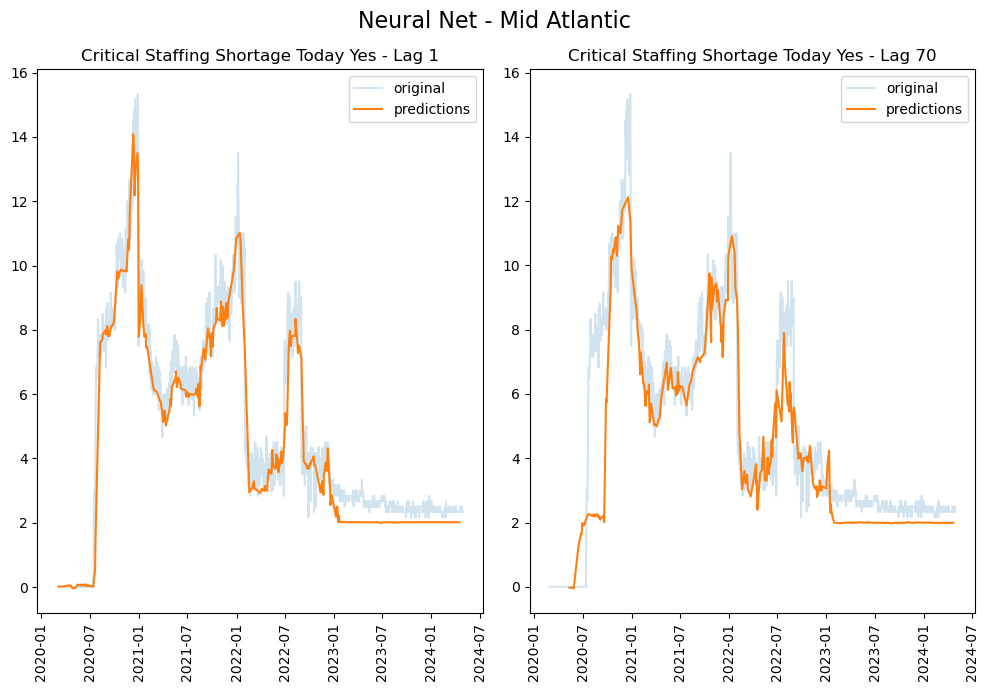

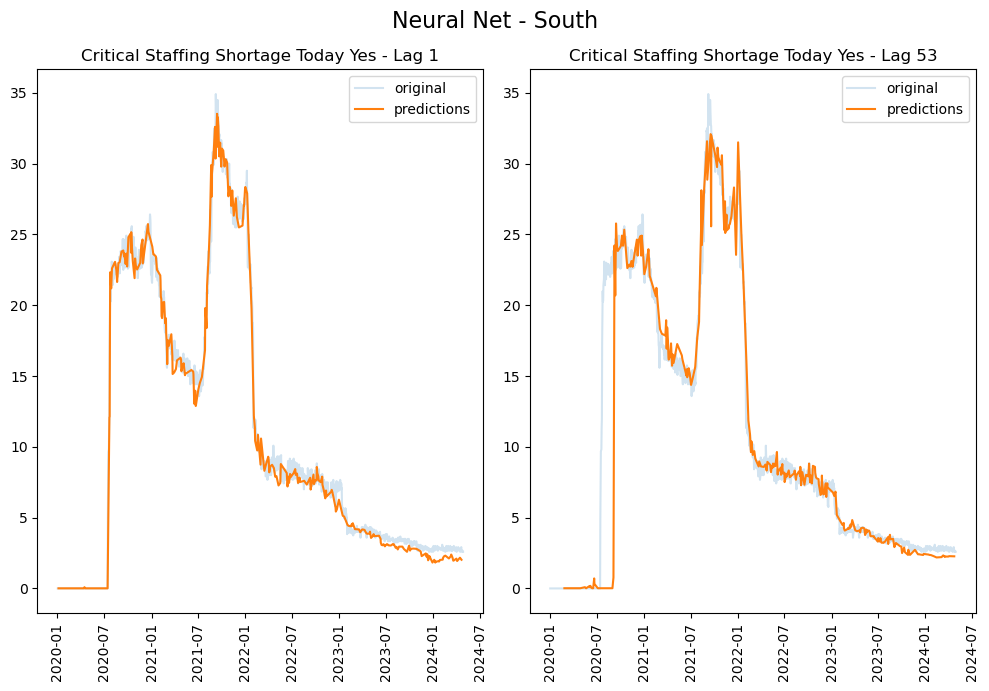

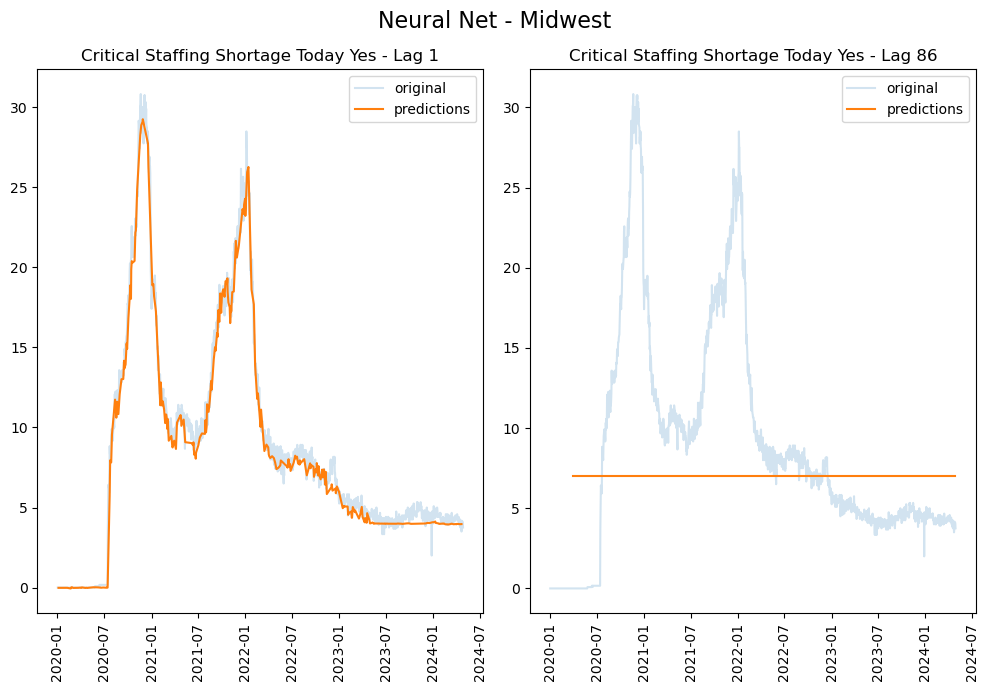

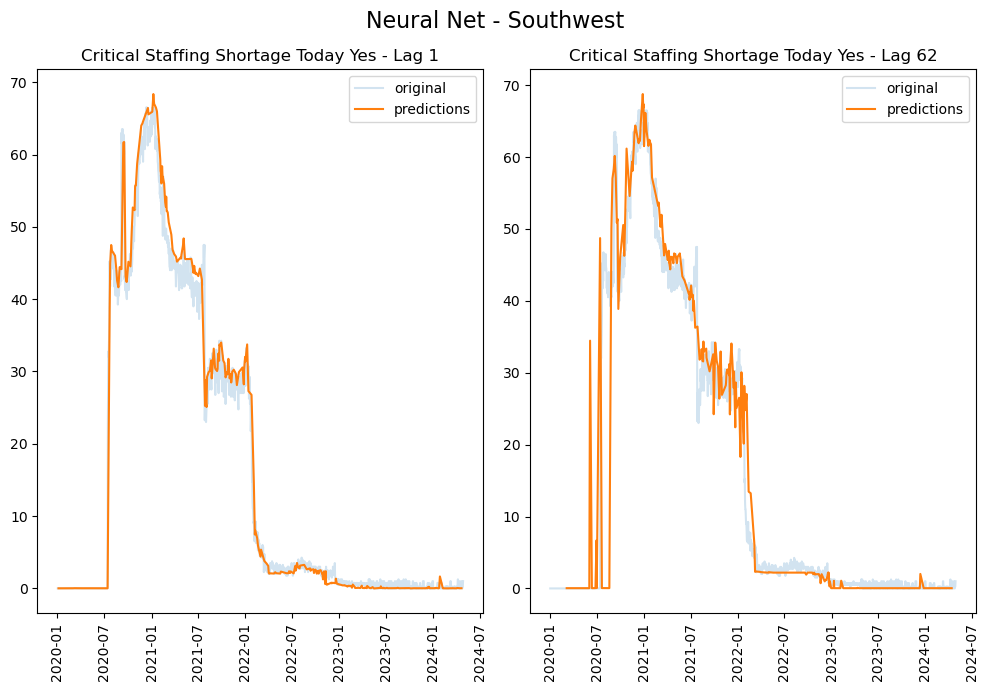

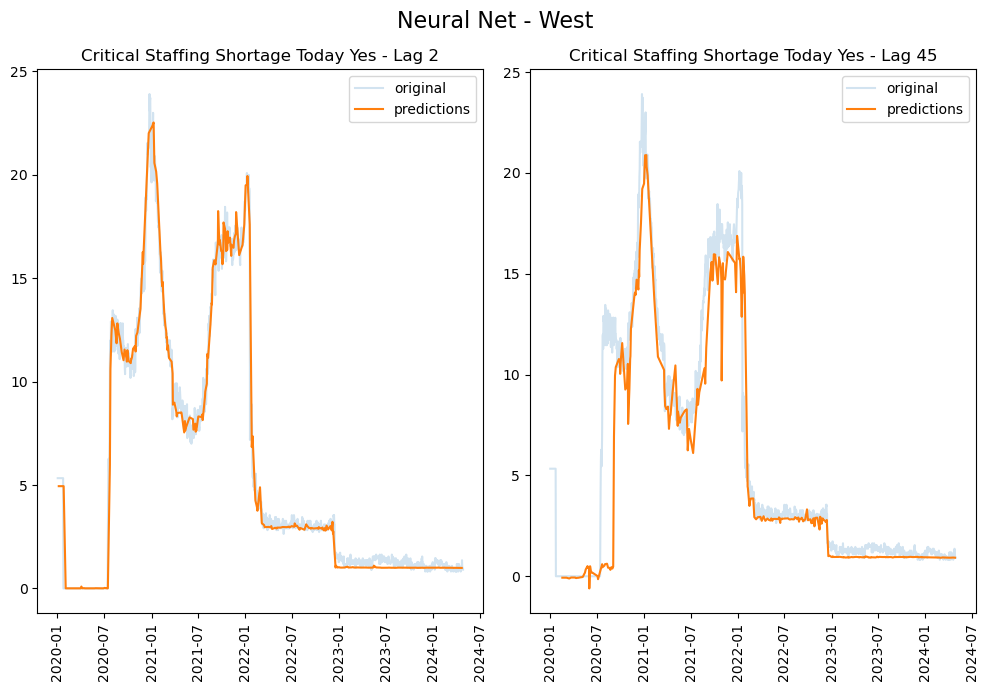

In [119]:
# get best model index
for region, val in preds_nn.items():
    best, worst = best_worst_r2s_nn[region]
    means = rolling_dfs["rolling_dfs_region_1"][region]["critical_staffing_shortage_today_yes"]
    test, pred = preds_nn[region][best]
    p = pd.DataFrame(data=pred.detach().numpy().reshape(pred.detach().numpy().size, -1), index=test.index).sort_values(by="date")
    plt.subplots(1,2, figsize=(10,7), tight_layout=True)
    plt.suptitle(f'Neural Net - {region}', fontsize=16)
    
    plt.subplot(1,2,1)
    plt.plot(means.index, means, label="original", alpha=0.2)
    plt.plot(p.index, p, label="predictions")
    plt.title(f"Critical Staffing Shortage Today Yes - Lag {best + 1}")
    plt.xticks(rotation=90)
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(means.index, means, label="original", alpha=0.2)
    test, pred = preds_nn[region][worst]
    p = pd.DataFrame(data=pred.detach().numpy().reshape(pred.detach().numpy().size, -1), index=test.index).sort_values(by="date")
    plt.plot(p.index, p, label="predictions")
    plt.title(f"Critical Staffing Shortage Today Yes - Lag {worst + 1}")
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"../img/nn_model_{region.lower().replace(" ","_")}.png", format="png", dpi=300)
    plt.show()

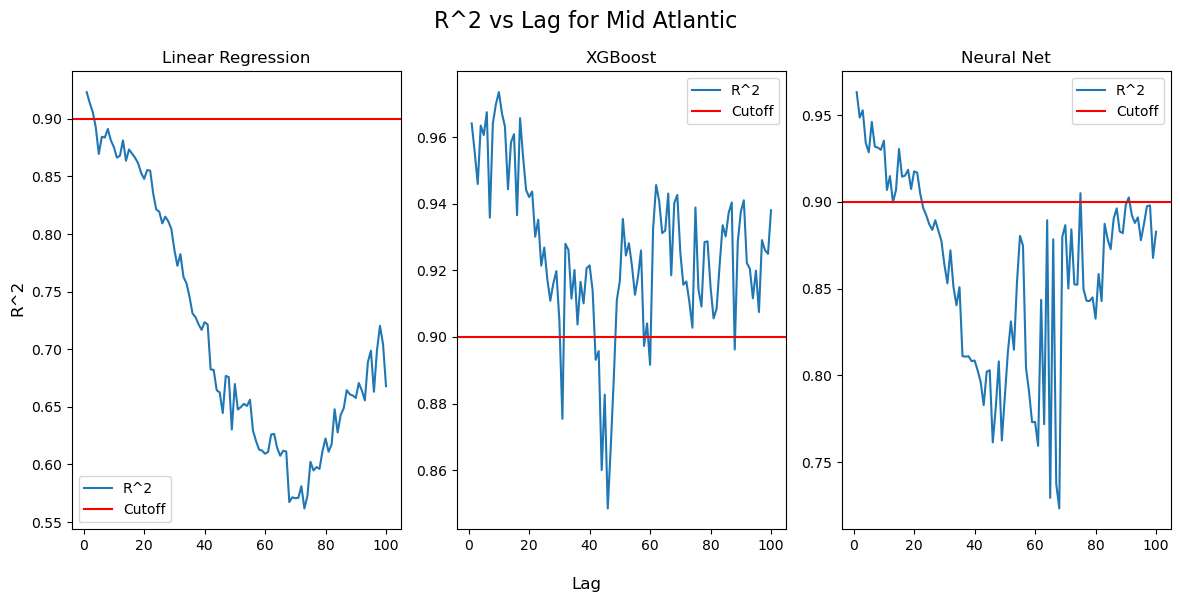

In [824]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(12, 6))
fig.suptitle("R^2 vs Lag for Mid Atlantic", fontsize=16)
fig.supxlabel("Lag")
fig.supylabel("R^2")

# linear
ax1.plot(range(1,101), accs["Mid Atlantic"], label="R^2")
ax1.set_title("Linear Regression")
ax1.axhline(.90, color="red", label="Cutoff")
ax1.legend()

ax2.plot(range(1,101), accs_xgb["Mid Atlantic"], label="R^2")
ax2.set_title("XGBoost")
ax2.axhline(.90, color="red", label="Cutoff")
ax2.legend()

ax3.plot(range(1,101), accs_nn["Mid Atlantic"], label="R^2")
ax3.set_title("Neural Net")
ax3.axhline(.90, color="red", label="Cutoff")
ax3.legend()

plt.savefig(f"../img/r2_complete_mid_atlantic.png", format="png", dpi=300)
plt.show()

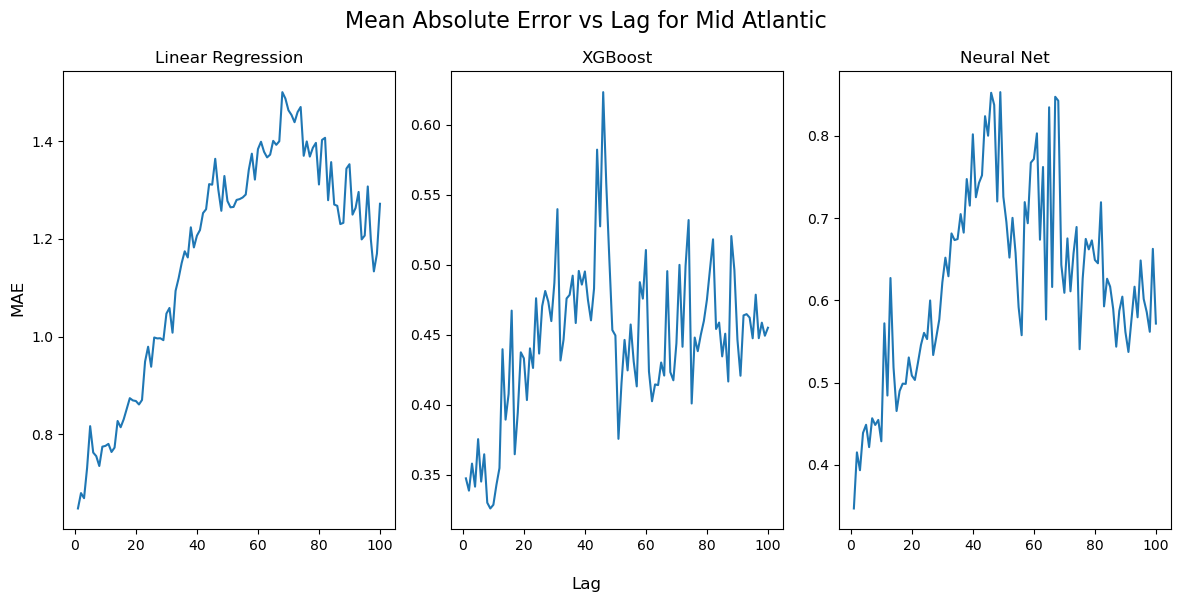

In [832]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(12, 6))
fig.suptitle("Mean Absolute Error vs Lag for Mid Atlantic", fontsize=16)
fig.supxlabel("Lag")
fig.supylabel("MAE")

# linear
ax1.plot(range(1,101), errors["Mid Atlantic"])
ax1.set_title("Linear Regression")

ax2.plot(range(1,101), errors_xgb["Mid Atlantic"])
ax2.set_title("XGBoost")

ax3.plot(range(1,101), errors_nn["Mid Atlantic"])
ax3.set_title("Neural Net")

plt.savefig(f"../img/error_complete_mid_atlantic.png", format="png", dpi=300)
plt.show()

In [54]:
best_linear_region = {}
for region, best_worst in best_worst_r2s_linear.items():
    best = best_worst[0]
    best_linear_region[region] = (best, rolling_dfs[f"rolling_dfs_region_{best+1}"][region], features_by_region_lagged[f"features_by_region_{best+1}"][region])

In [62]:
def save_best_models(model, df, region, coefs, prefix):
    X = df[coefs]
    y = df["critical_staffing_shortage_today_yes"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    my_scaler = StandardScaler()
    X_train_scaled = my_scaler.fit_transform(X_train)
    X_test_scaled = my_scaler.transform(X_test)
    model.fit(X_train_scaled, y_train)
    filename = f"{prefix}_{region.lower().replace(" ", "_")}.pkl"
    joblib.dump(model, f'../models/{filename}')
    return filename

In [69]:
r2_pkl_lr = {}

for region, best_df_features in best_linear_region.items():
    best, df, features = best_df_features
    filename = save_best_models(LinearRegression(), df, region, features, "lr")
    r2_pkl_lr[region] = {
        "r2": accs[region][best],
        "filename": filename,
        "features": features
    }

In [78]:
with open("../data/r2_pkl_lr.json", "w") as outfile: 
    json.dump(r2_pkl_lr, outfile)

In [91]:
best_xgb_region = {}
for region, best_worst in best_worst_r2s_xgb.items():
    best = best_worst[0]
    best_xgb_region[region] = (best, rolling_dfs[f"rolling_dfs_region_{best+1}"][region], features_by_region_lagged[f"features_by_region_{best+1}"][region])

In [98]:
r2_pkl_xgb = {}

for region, best_df_features in best_xgb_region.items():
    best, df, features = best_df_features
    filename = save_best_models(XGBRegressor(), df, region, features, "xgb")
    r2_pkl_xgb[region] = {
        "r2": accs_xgb[region][best],
        "filename": filename,
        "features": features
    }

In [100]:
with open("../data/r2_pkl_xgb.json", "w") as outfile: 
    json.dump(r2_pkl_xgb, outfile)

In [122]:
best_nn_region = {}
for region, best_worst in best_worst_r2s_nn.items():
    best = best_worst[0]
    best_nn_region[region] = (best, rolling_dfs[f"rolling_dfs_region_{best+1}"][region], features_by_region_lagged[f"features_by_region_{best+1}"][region])

In [154]:
def save_neural_net(df, region, coefs):
    filename = f"nn_{region.lower().replace(" ", "_")}.pt"
    X = df[coefs]
    y = df[["critical_staffing_shortage_today_yes"]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    my_scaler = StandardScaler()
    X_train_scaled = my_scaler.fit_transform(X_train)
    X_test_scaled = my_scaler.transform(X_test)
    
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

    NN_model = SimpleNN(X_train_tensor.shape[1])

    l1_loss = nn.L1Loss() # this includes the softmax
    # Weight decay .01
    optimizer = torch.optim.SGD(NN_model.parameters(), lr=.01, momentum=0.9, weight_decay=0.01)
    
    for epoch in range(500):
        # Clear gradients (pytorch accumulates gradients by default)
        optimizer.zero_grad()
    
        # Calculate outputs
        output_values = NN_model(X_train_tensor)
    
        # Calculate loss
        loss = l1_loss(output_values, y_train_tensor)
    
        # Backpropagation & weight adjustment
        loss.backward()
        optimizer.step()

    torch.save(NN_model, f'../models/{filename}')
    
    return filename

In [156]:
r2_pkl_nn = {}

for region, best_df_features in best_nn_region.items():
    best, df, features = best_df_features
    filename = save_neural_net(df, region, features)
    r2_pkl_nn[region] = {
        "r2": accs_nn[region][best],
        "filename": filename,
        "features": features
    }

In [158]:
with open("../data/r2_pkl_nn.json", "w") as outfile: 
    json.dump(r2_pkl_nn, outfile)